In [29]:
# Step 1: Import Required Libraries\n",
# The notebook starts by importing all the necessary Python libraries for:\n",
# Data handling → pandas, numpy\n",
# Machine learning → scikit-learn\n",
# Visualization → matplotlib, shap, plotly\n",
# Warnings suppression → warnings\n",
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Step 2 : Load and Prepare Dataset
# Load your input CSV file (EQUIP_Input_3.csv).
# Select the features and target variable (Ln(P)_Mpa).
# Standardize (normalize) feature values using StandardScaler.
# Split data into training (80%) and test (20%) sets.
data = pd.read_csv('EQUIP_Input.csv')
Features = ['Temperature', 'CR', 'Mass', 'FIE', 'BM', 'HF', 'MV', 'M-H_Bond', 'M-H_Eng',
            'formation_H', 'vol_H', 'vol_diff', 'EN.Diff', 'Atomic.Size.Diff', 'dSmix']
scaler = StandardScaler()
data[Features] = scaler.fit_transform(data[Features])
X = data[Features]
y = data["Ln(P)_Mpa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [4]:
# Step 3: Dataset Overview
# Total points (unique composition–temperature pairs)
# Number of unique compositions
# This gives an overview of dataset diversity and coverage.


PCTs = len(data.drop_duplicates(['composition_final', 'Temperature']))
Unique_Compositions = len(data['composition_final'].unique())
total = data.shape[0]
print("No of PCT:", PCTs, "; No of unique composition:", Unique_Compositions, "total_points:", total)


No of PCT: 293 ; No of unique composition: 77 total_points: 293


In [11]:
# Step 4: Hyperparameter Optimization (Grid Search)
# Perform a grid search using GridSearchCV to find the best combination of:
# alpha (regularization strength)
# kernel type (linear, rbf, poly)
# gamma (kernel coefficient)
# The best estimator (model configuration) is printed.

param_grid = {
    'alpha': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5]
}

grid = GridSearchCV(KernelRidge(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_estimator_)


KernelRidge(alpha=0.001, gamma=0.1, kernel='rbf')


In [6]:

kr = GridSearchCV(KernelRidge(),
param_grid={'kernel': ['linear', 'rbf', 'poly'],
             "alpha": [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5],
             "gamma": [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5]})

kr.fit(X_train, y_train)

mae_train = mean_absolute_error(y_train, kr.predict(X_train))
mae_test = mean_absolute_error(y_test, kr.predict(X_test))
score_rr = kr.score(X_test, y_test)

print("MSE_train: %0.2f" % mae_train, "MAE_Test: %0.2f" % mae_test,
      "R2 score: %0.2f" % score_rr, kr.best_params_)


MSE_train: 0.09 MAE_Test: 0.11 R2 score: 0.99 {'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}


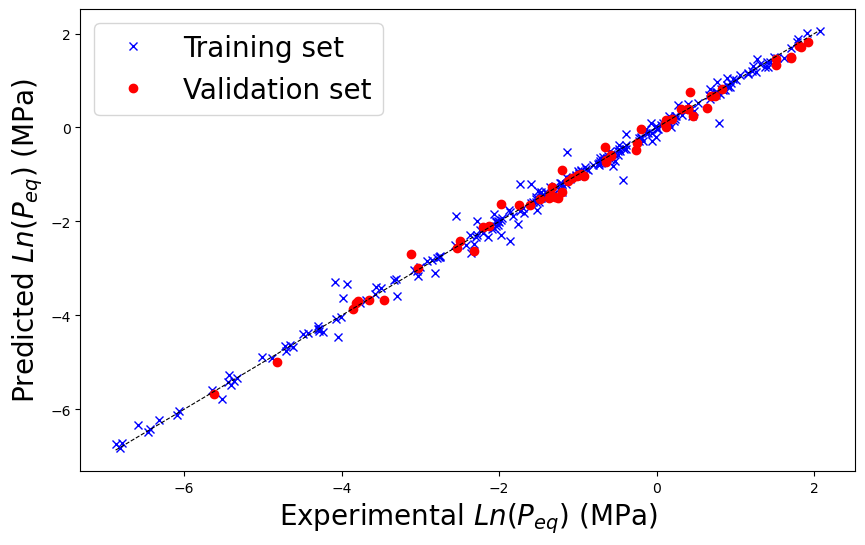

In [7]:
# Step 5: Train and Evaluate the Optimized Model
# Train the Kernel Ridge Regression (KRR) model using best hyperparameters.
# MAE (Mean Absolute Error) for train and test data
# R² Score (model fit accuracy)
# Save Parity Plot
#Visualize how well predicted values match experimental ones:
#Blue = training data
#Red = validation data
#Dashed line = perfect prediction

This shows model accuracy visually.
kr = KernelRidge(kernel='rbf', alpha=0.001, gamma=0.1)
kr.fit(X_train, y_train)
y_train_pred = kr.predict(X_train)
y_pred = kr.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(y_train, y_train_pred, 'xb', label='Training set')
plt.plot(y_test, y_pred, 'or', label='Validation set')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=0.8, color='black')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Experimental $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
plt.ylabel('Predicted $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
plt.savefig('OUTPUT/KRR_ML_EXP.png', format='png', dpi=800, bbox_inches='tight')
plt.show()


In [24]:
# Step 6.1: K-Fold Cross-Validation
# Perform 10-fold cross-validation to:
# Estimate performance robustness
# Compute average MAE and Explained Variance
# This gives statistical insight into model stability.
ss = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error','r2']
results = cross_validate(kr, X, y, cv=ss, scoring=scoring)
mae =results['test_neg_mean_absolute_error']
score = results['test_r2']
print(f" Avg_MAE: {-mae.mean():0.2f}","\n",f" MAE: {np.round(mae,2)}","\n",f"R2 Score: {score.mean():0.2f}", "\n", f"std: {score.std():0.2f}","\n", f"score: {np.round(score,2)}")

 Avg_MAE: 0.16 
  MAE: [-0.11 -0.18 -0.13 -0.19 -0.19] 
 R2 Score: 0.98 
 std: 0.01 
 score: [0.99 0.97 0.99 0.97 0.97]


In [27]:
# Step 6.2: Shuffle Split Validation
# A second validation method that:
# Randomly splits data multiple times
# Tests consistency across different train-test partitions
# This complements K-Fold results.

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=520)
score1_ss = cross_validate(kr, X,y, cv=cv, scoring=scoring)
mae_ss = score1_ss['test_neg_mean_absolute_error']
score_ss = score1_ss['test_r2']
print(f"MAE: {-mae_ss.mean():0.2f}","\n",f"R2 Score: {score_ss.mean():0.2f}" "\n", f"std: {score_ss.std():0.2f}",)

MAE: 0.16 
 R2 Score: 0.98
 std: 0.02


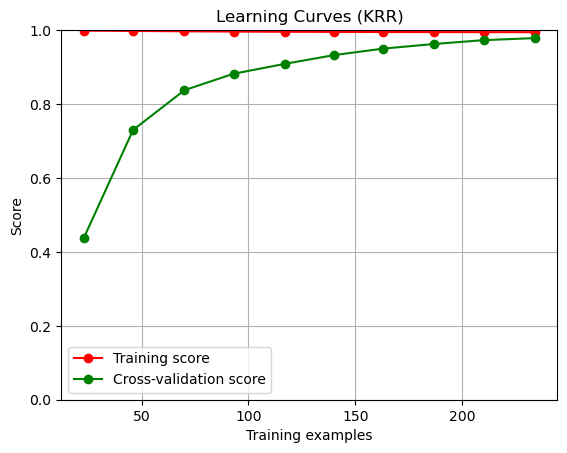

In [32]:
# Step 6.3: Plot Learning Curve
# Plots training vs. validation performance as training size increases.
# Reveals if the model suffers from bias or variance.
# Helps confirm if adding data improves learning.

title = ("Learning Curves (KRR)" )
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=200, test_size=0.2, random_state=0)
estimator = kr
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=cv,train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,  train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt
plot_learning_curve(estimator, title, X, y, ylim=(0.00, 1.0), cv=cv)

plt.show()

   k  mean_mae   std_mae  mean_mse  std_mse   mean_r2    std_r2
0  2  0.303845  0.049385  0.275217  0.09887  0.924508  0.035928
1  3  0.202493  0.032725  0.104133  0.03606  0.973137  0.006793


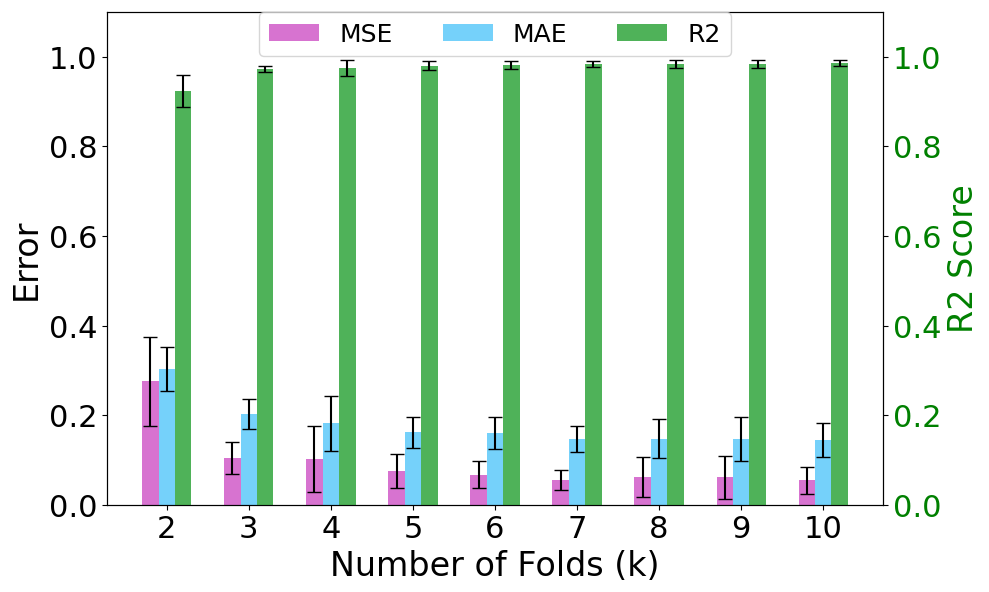

In [38]:
# Step 6.4: Evaluate Model for Different K Values
# Run multiple K-fold validations (for K = 2 → 10)
# to see how error metrics change with the number of folds.
# Calculates and stores:
# Mean and standard deviation of MAE, MSE, R²
# Results are stored in a DataFrame (results_df).
# Define metrics and storage

# Visualize Cross-Validation Metrics
# Create a bar plot showing:
# MAE and MSE (left y-axis)
# R² (right y-axis)
# for each k value.
# This helps compare model stability as the number of folds varies.

scoring = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2'
}
k_values = np.arange(2,11,1)
results = []

# Iterate over different k values
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Run cross-validation once for all metrics
    cv_results = cross_validate(kr, X, y, cv=kf, scoring=scoring)
    
    # Compute mean and std for each metric
    mean_mae = -np.mean(cv_results['test_mae'])
    std_mae = np.std(cv_results['test_mae'])
    mean_mse = -np.mean(cv_results['test_mse'])
    std_mse = np.std(cv_results['test_mse'])
    mean_r2 = np.mean(cv_results['test_r2'])
    std_r2 = np.std(cv_results['test_r2'])
    
    # Store results in a structured format
    results.append({
        'k': k,
        'mean_mae': mean_mae,
        'std_mae': std_mae,
        'mean_mse': mean_mse,
        'std_mse': std_mse,
        'mean_r2': mean_r2,
        'std_r2': std_r2
    })

# Convert to DataFrame for easy plotting and analysis
results_df = pd.DataFrame(results)
print(results_df.head(2))

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xticks(k_values, k_values, fontsize=22)
# Bar plot with error bars for Mean Absolute Error (MAE)
bar_width = 0.2
ax1.set_ylim(0, 1.1)
k_values_shifted = k_values - bar_width
ax1.bar(k_values_shifted, results_df['mean_mse'], width=bar_width, yerr=results_df['std_mse'], capsize=5, color='#C738BD', alpha=0.7, label='MSE')
ax1.bar(k_values, results_df['mean_mae'], width=bar_width, yerr=results_df['std_mae'], capsize=5, color='#3ABEF9', alpha=0.7, label='MAE')
ax1.set_xlabel('Number of Folds (k)', fontsize=24)
ax1.set_ylabel('Error', fontsize=24)
ax1.tick_params(axis='y', labelsize=22)

ax2 = ax1.twinx()
ax2.set_ylim(0, 1.2)
ax2.bar(k_values + bar_width, results_df['mean_r2'], width=bar_width, yerr=results_df['std_r2'], capsize=5, color='#059212', alpha=0.7, label='R2')
ax2.set_ylabel('R2 Score', color='g', fontsize=24)
ax2.tick_params(axis='y', labelcolor='g', labelsize=22)
plt.ylim(0,1.1)

# Add legend
fig.legend(loc='upper center',shadow=False, ncol=3, fontsize=18)

plt.tight_layout()
plt.savefig('OUTPUT/KRR_ML_K-fold.png',format='png',dpi=800, bbox_inches='tight')
plt.show()

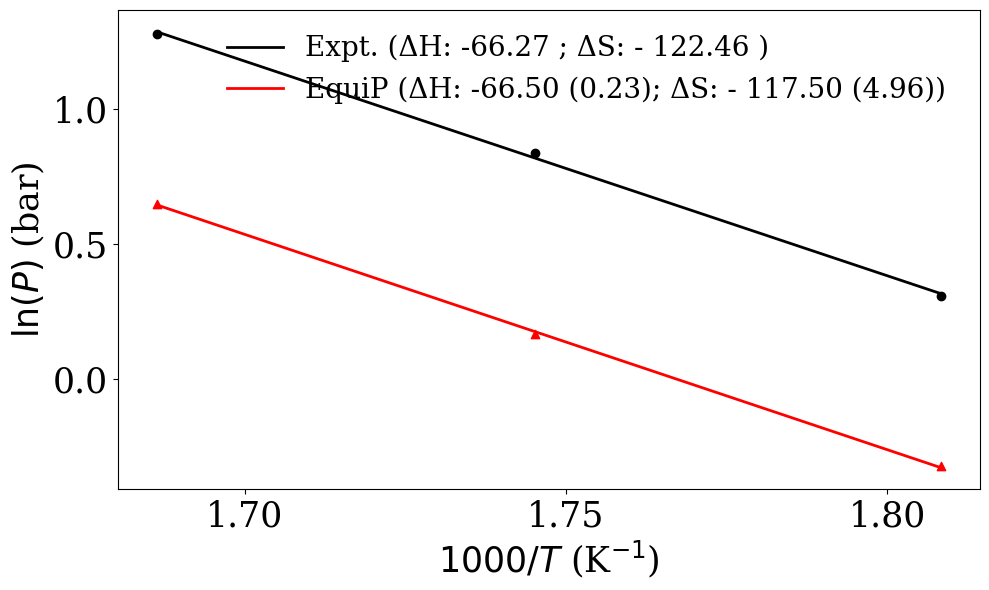

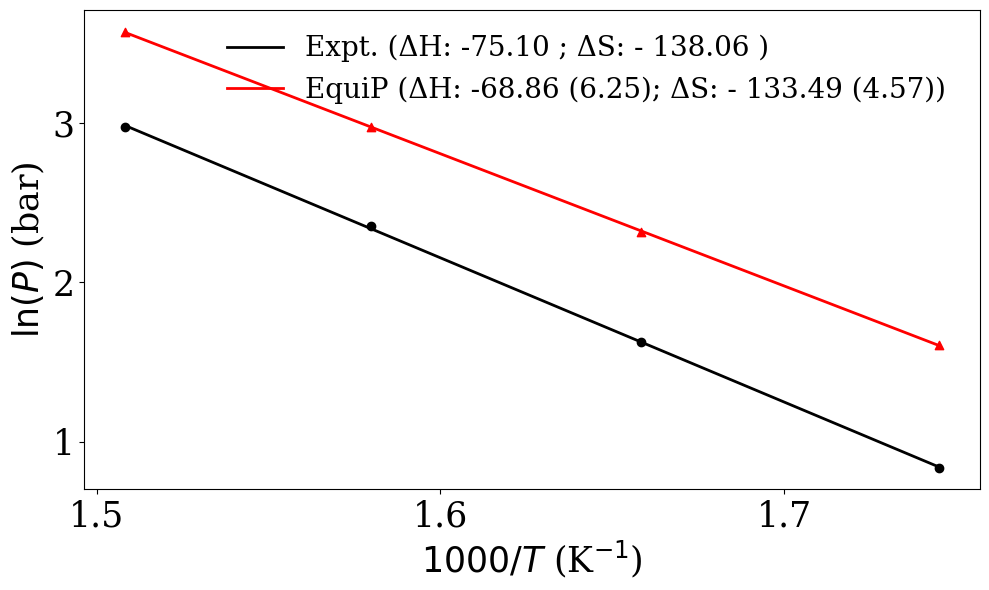

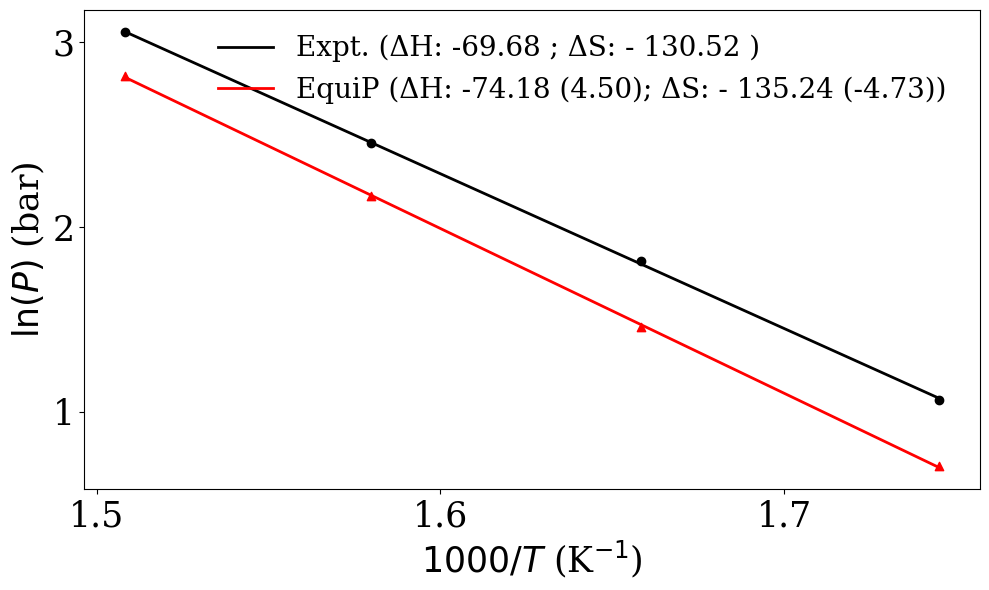

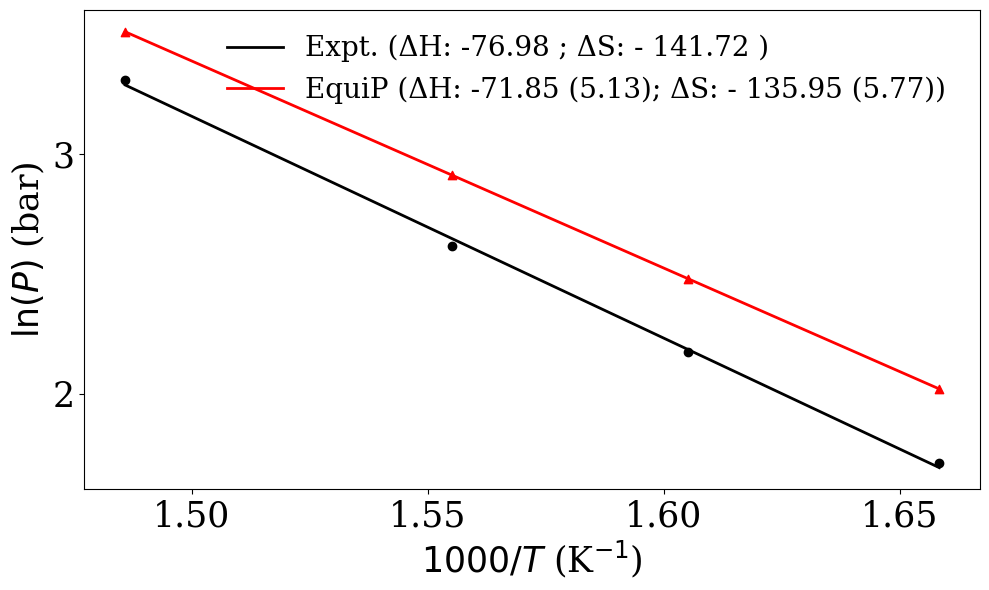

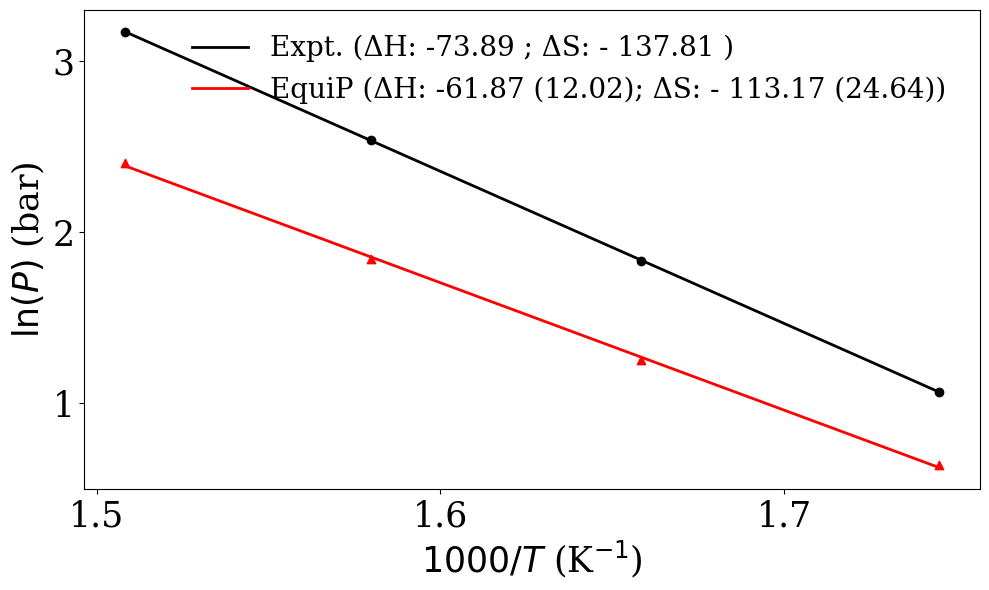

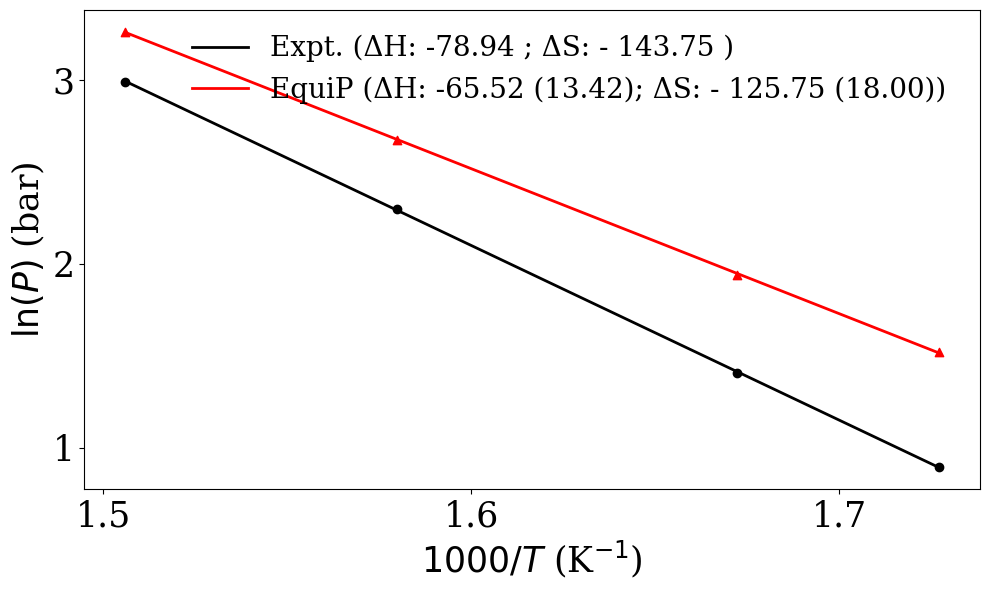

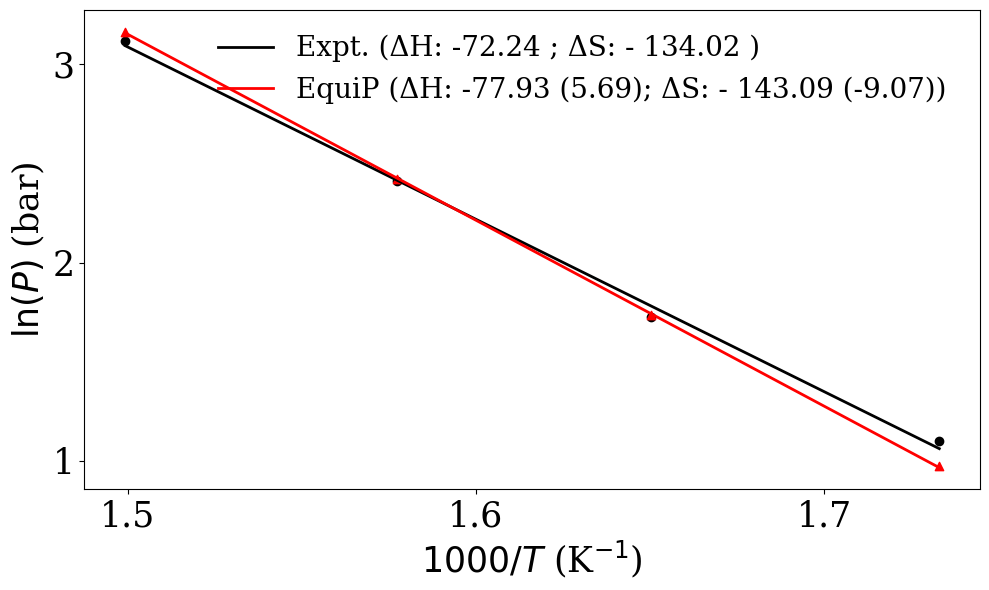

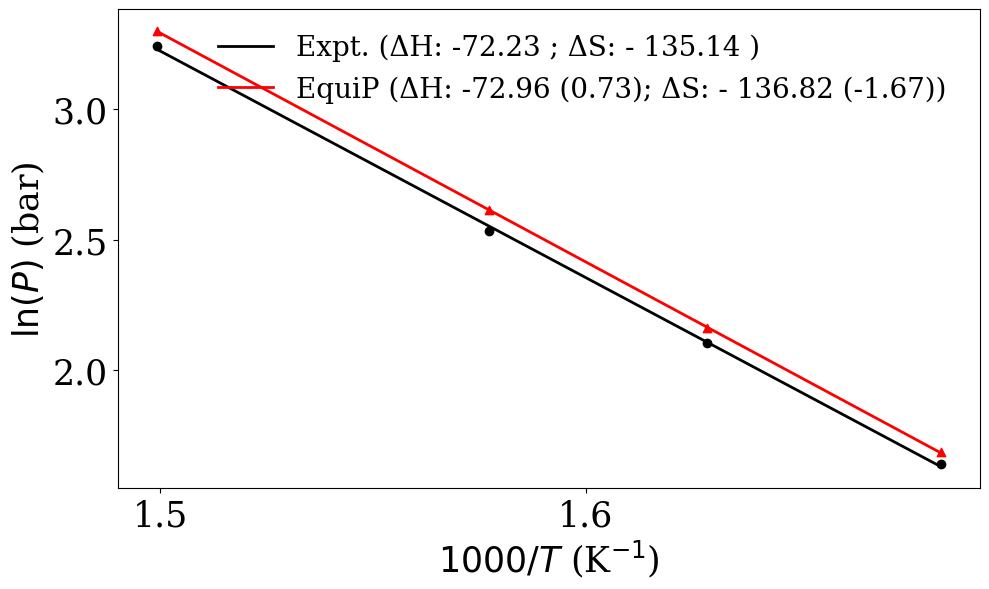

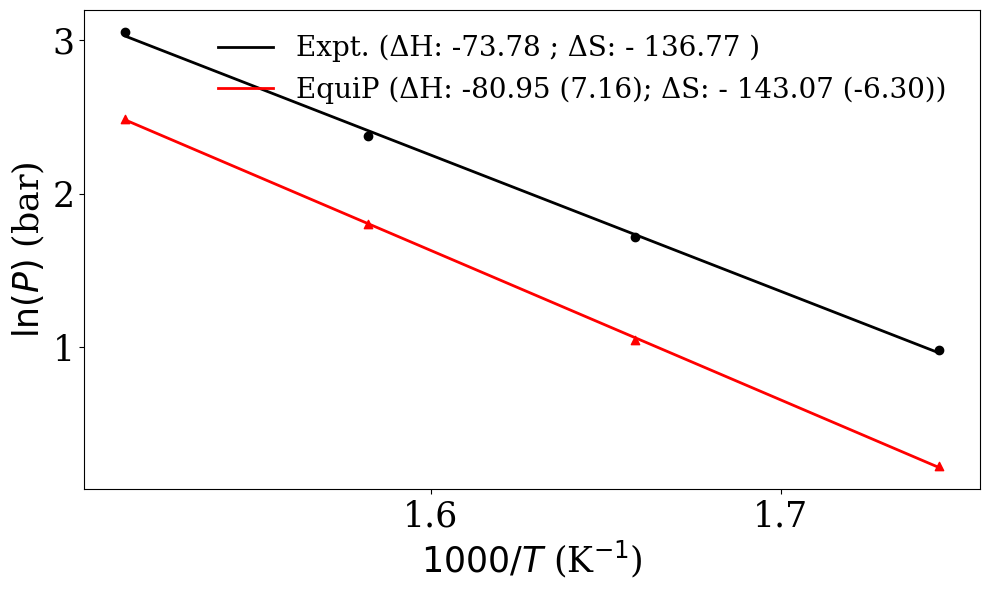

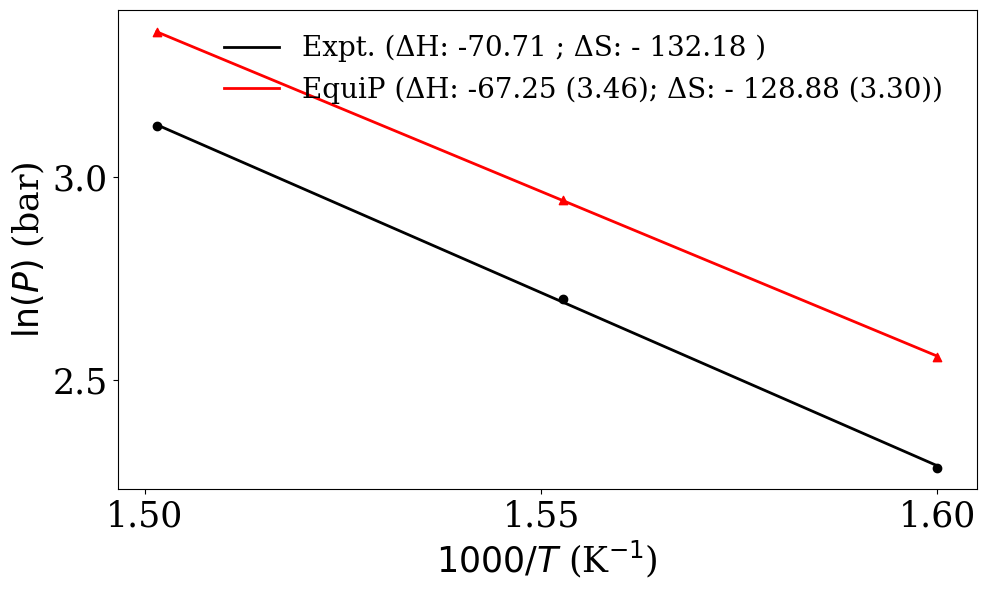

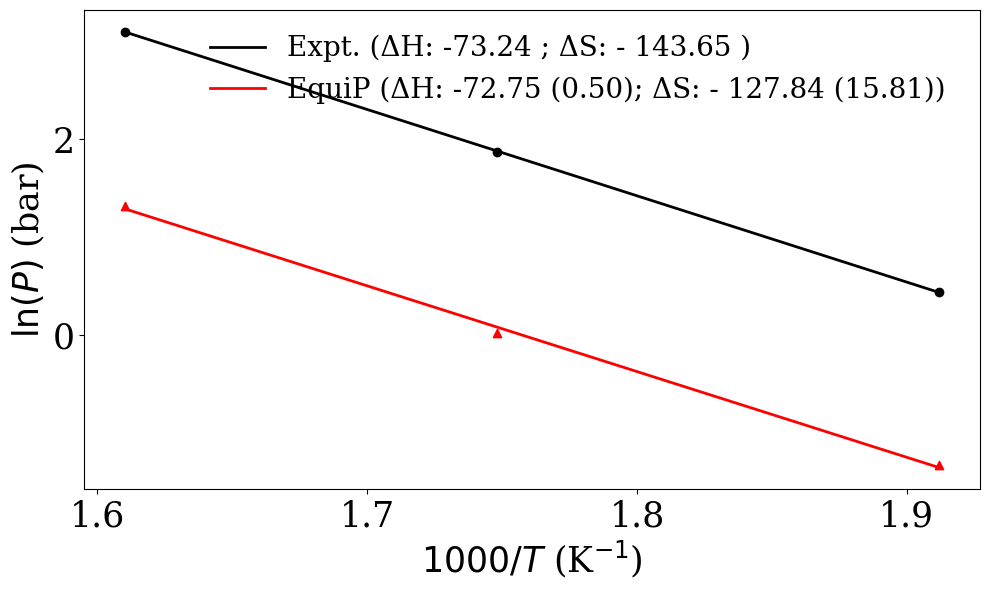

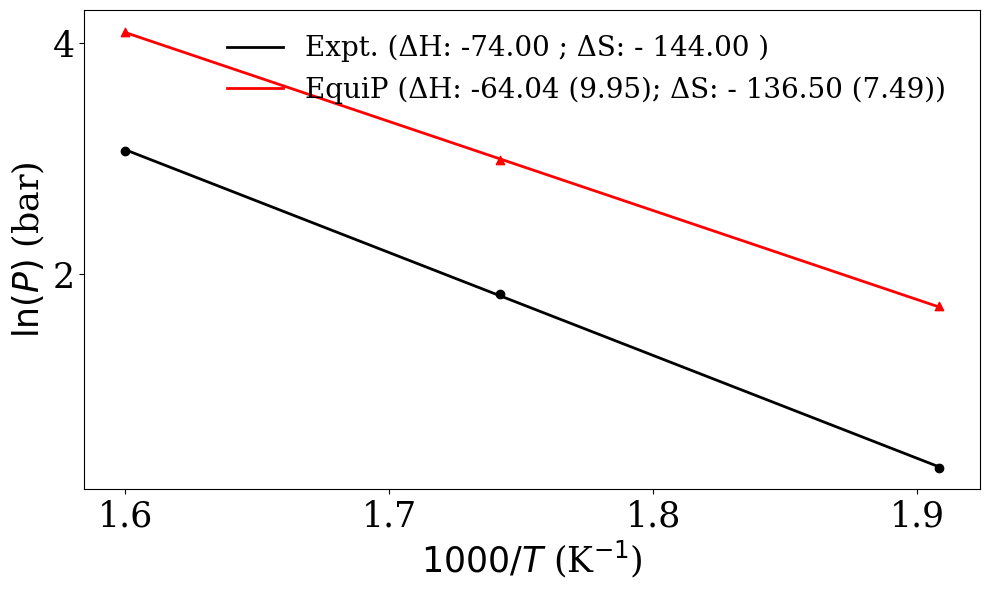

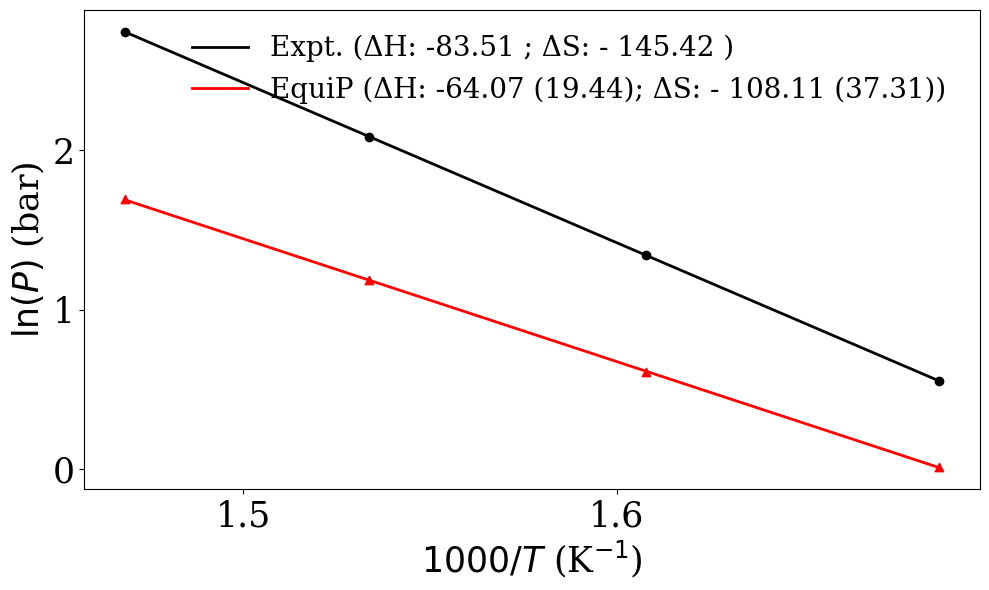

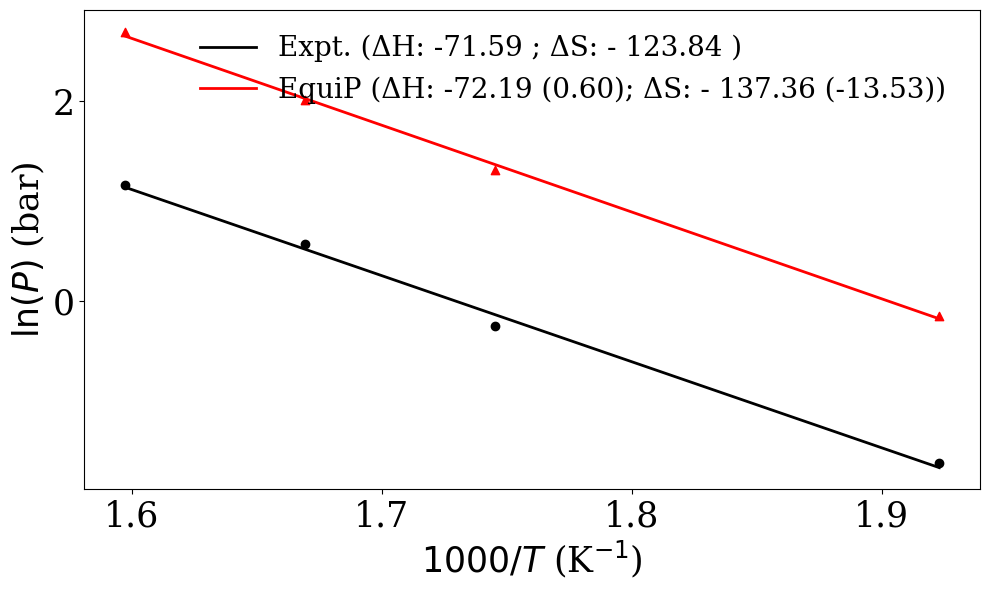

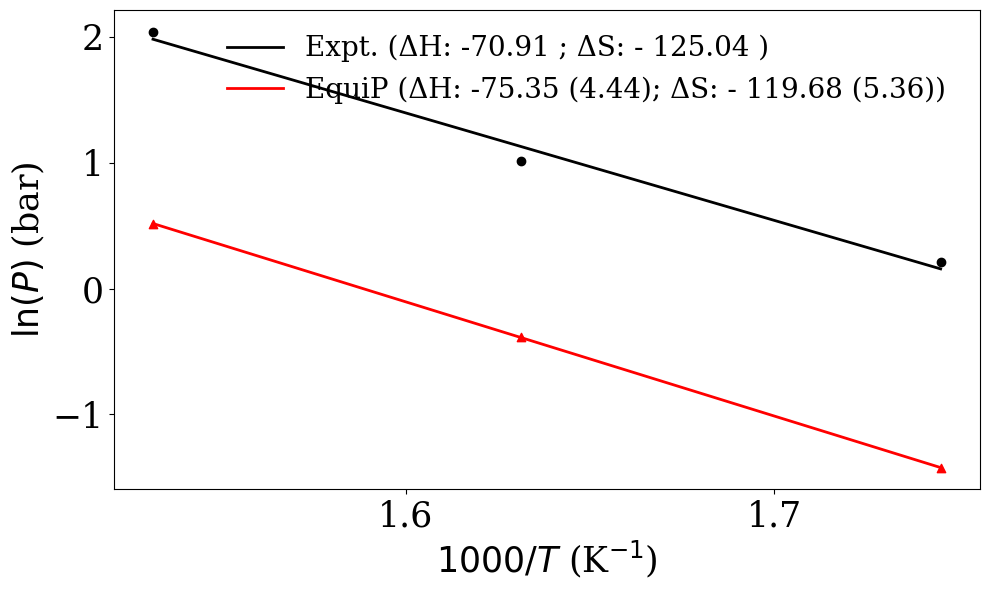

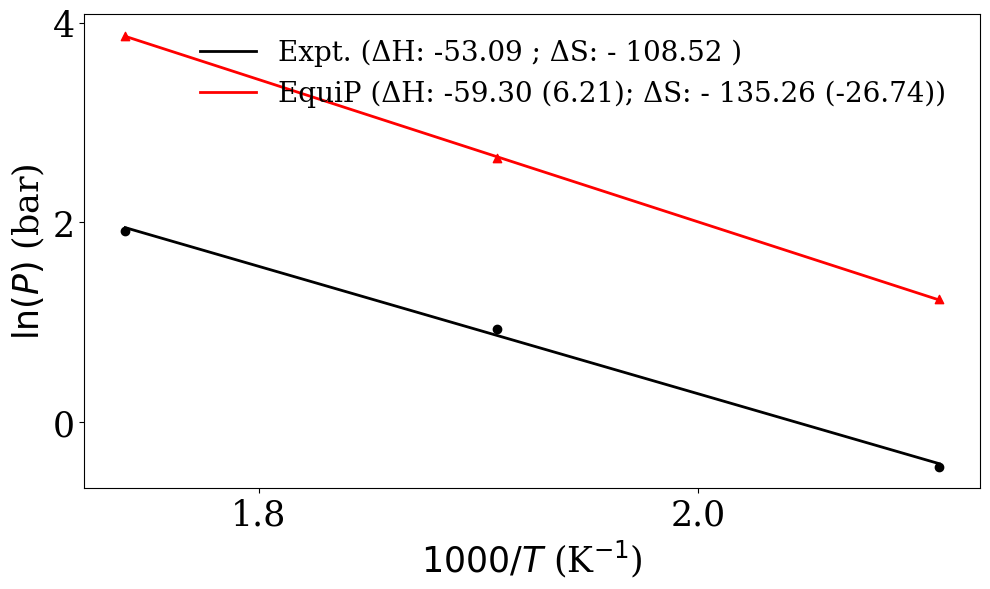

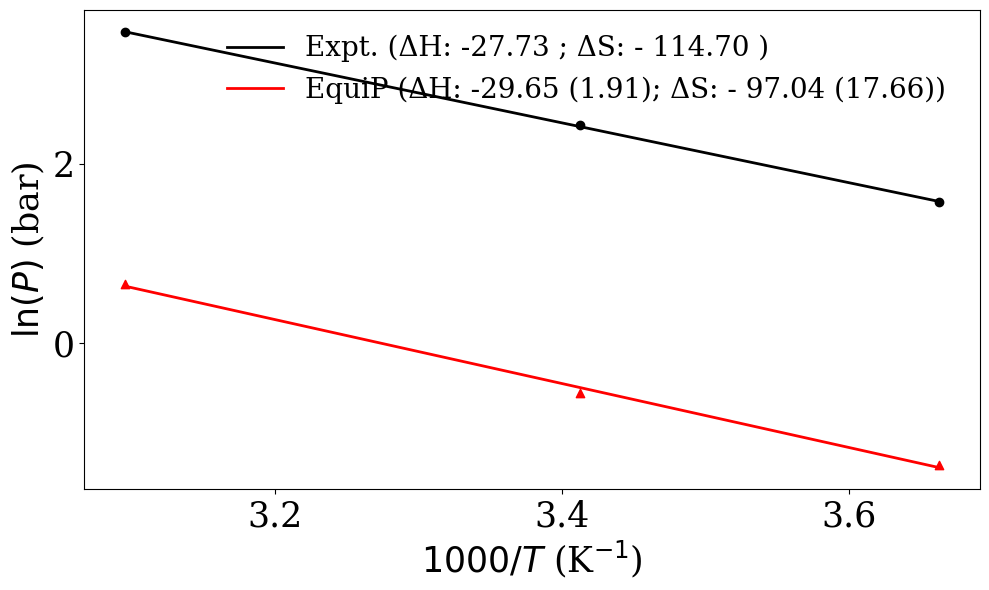

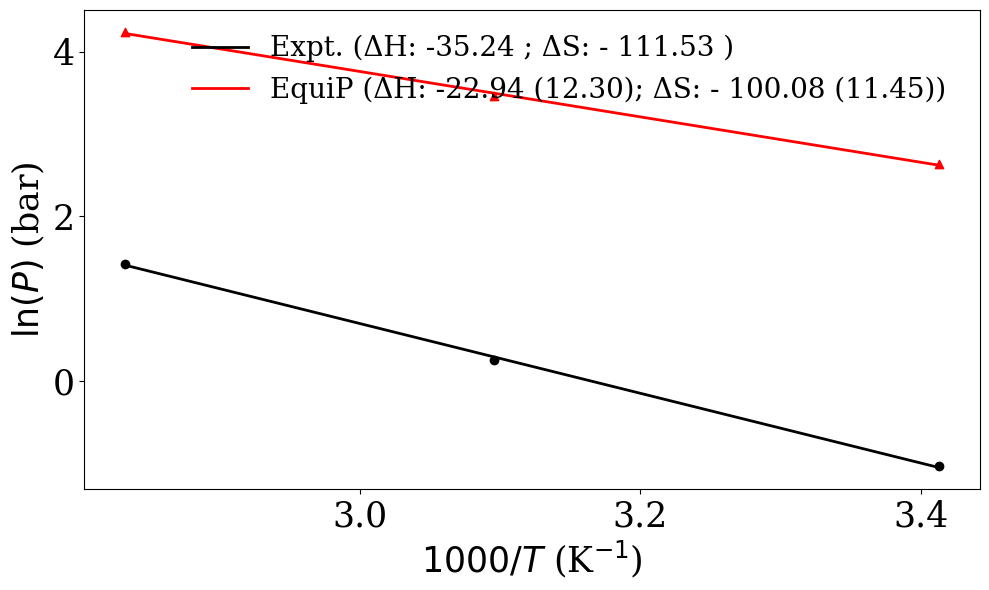

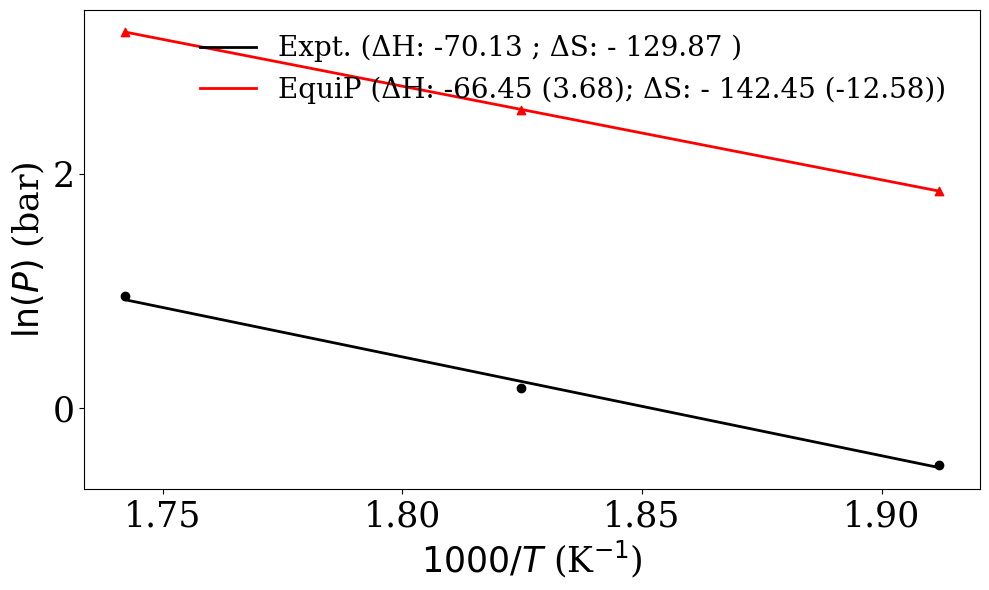

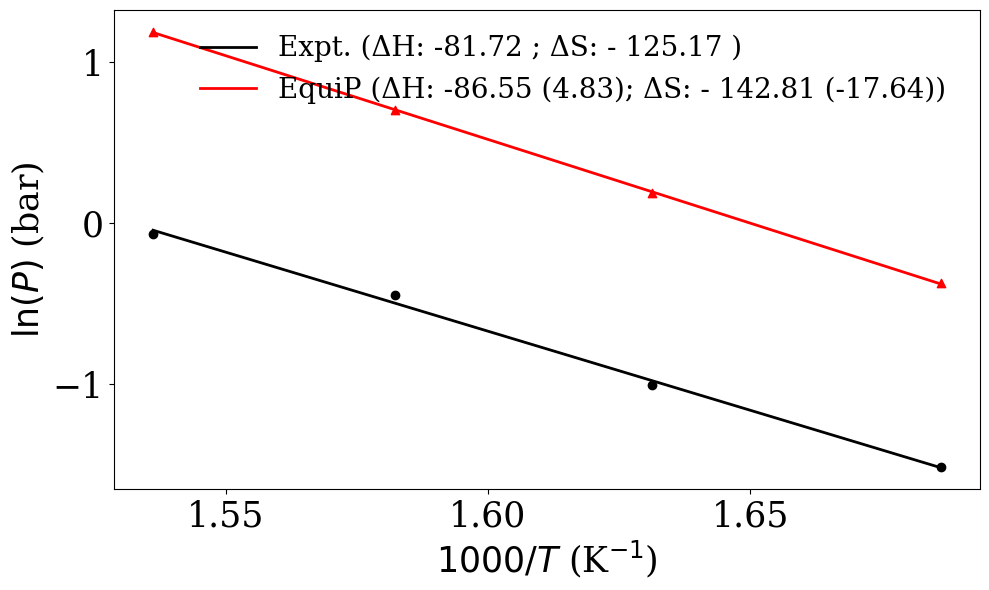

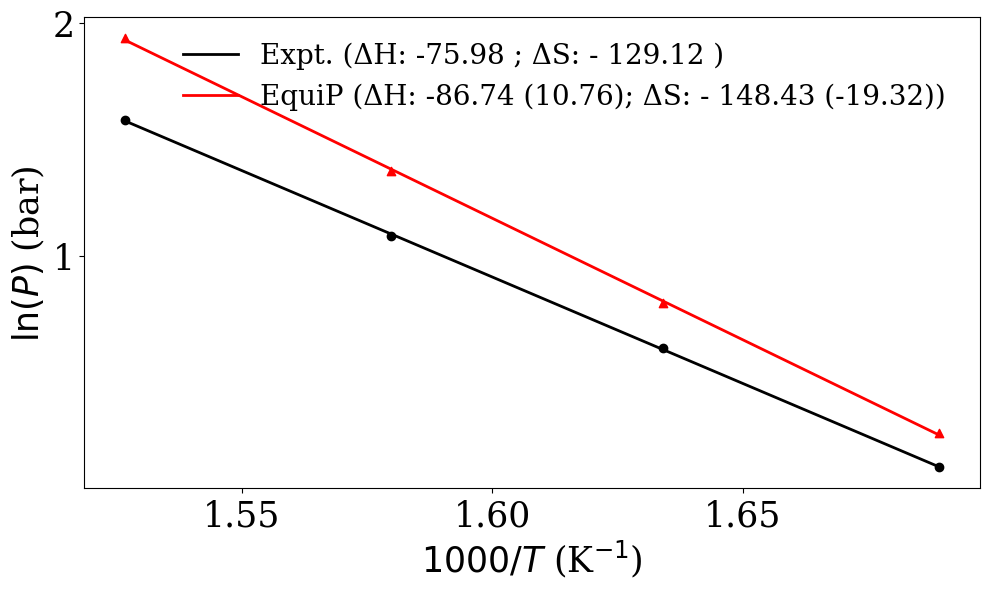

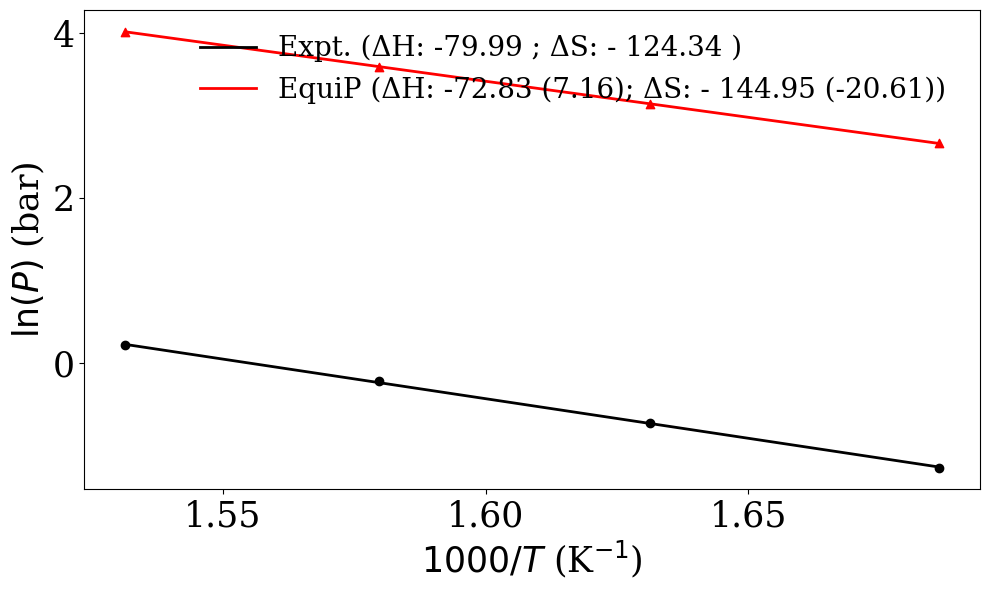

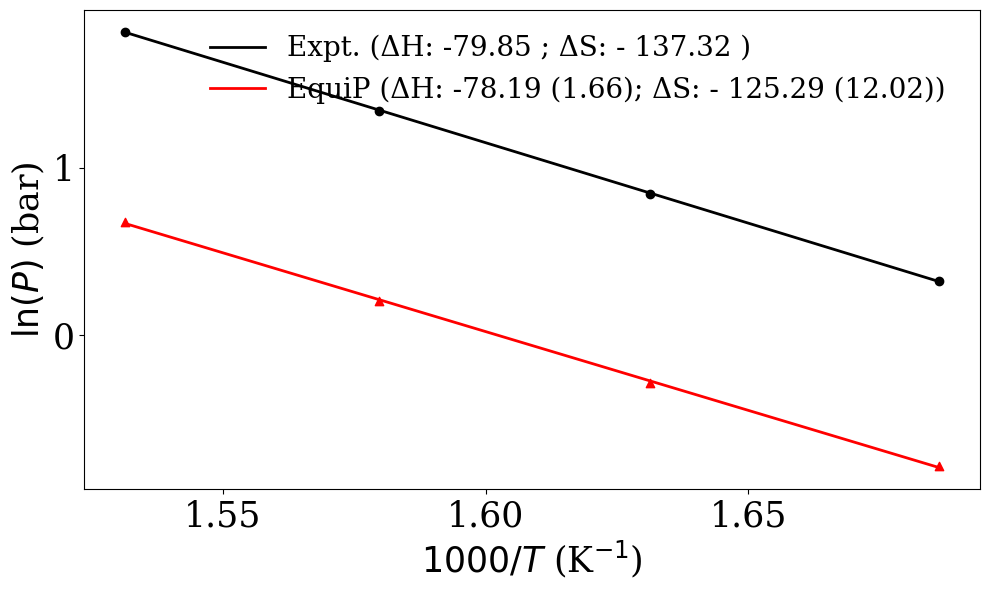

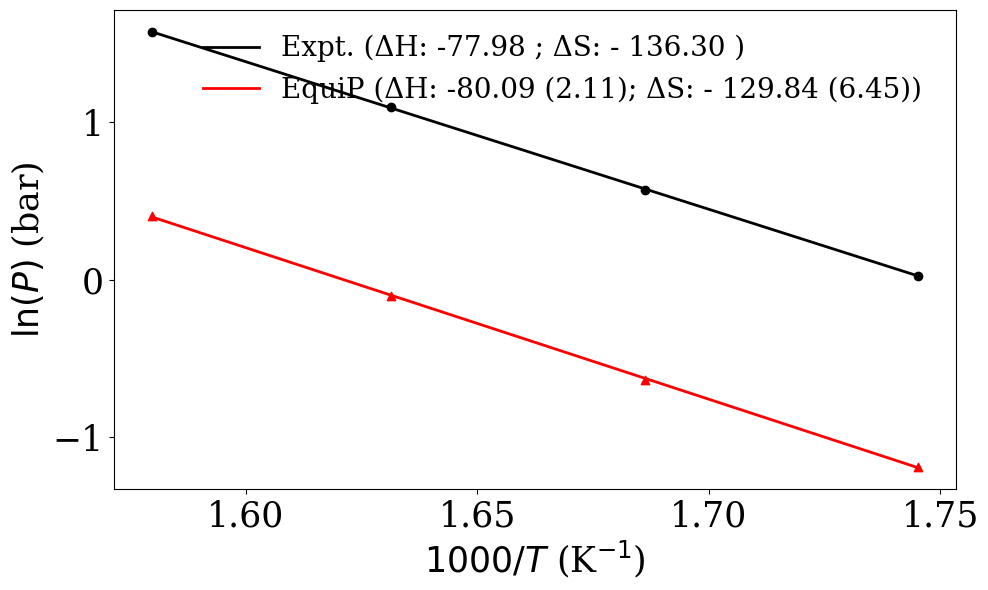

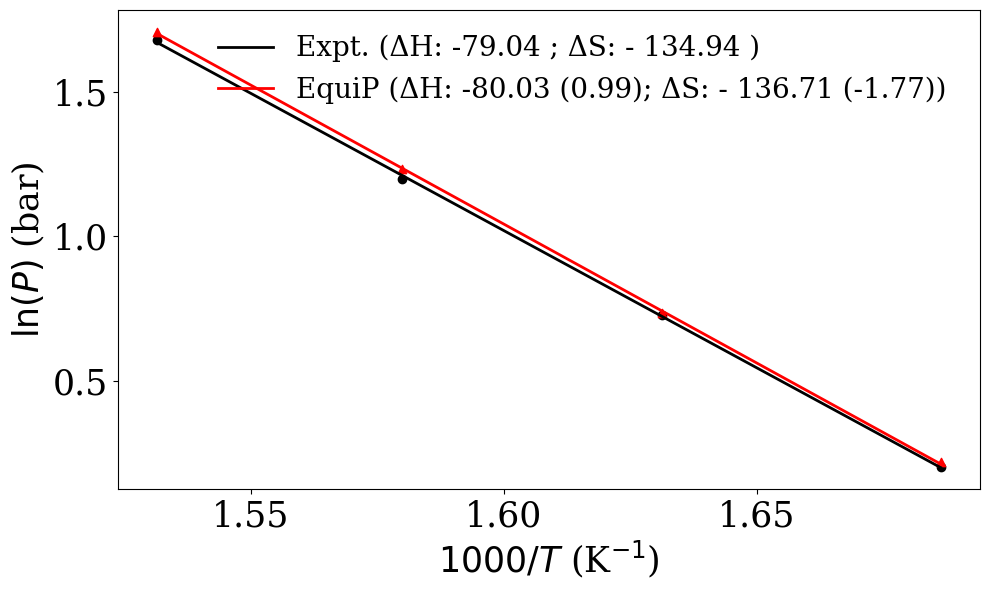

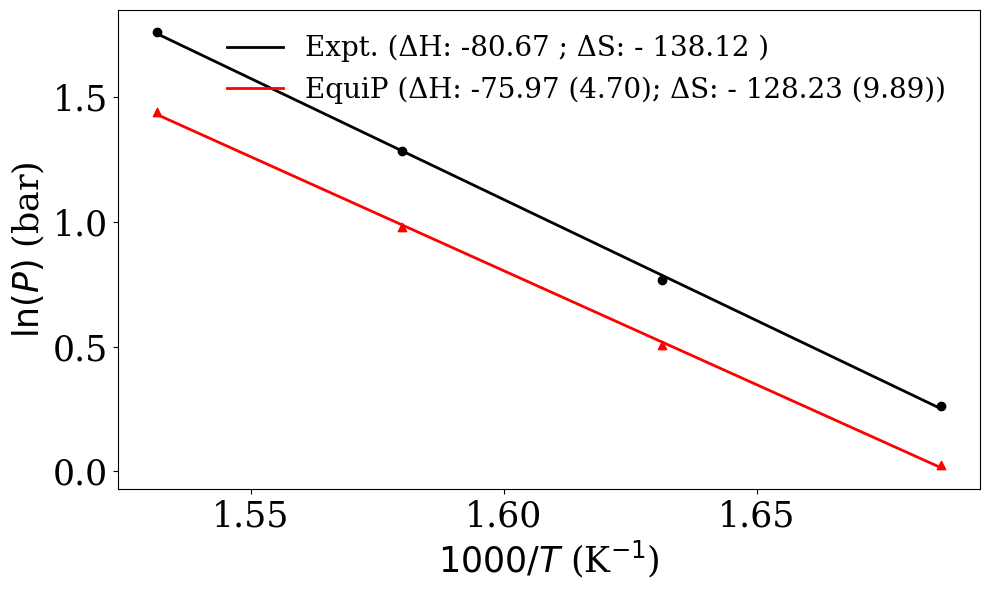

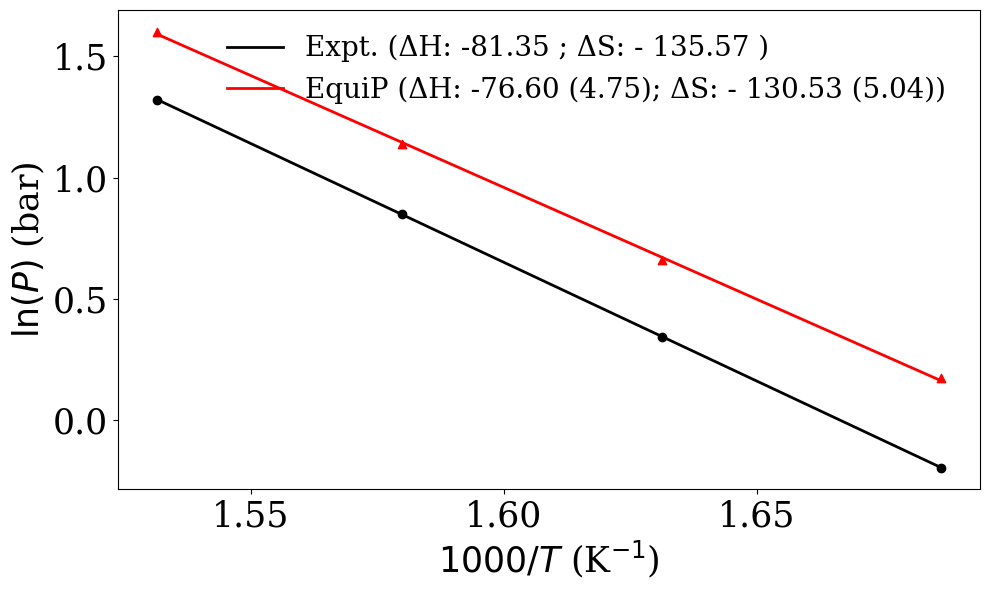

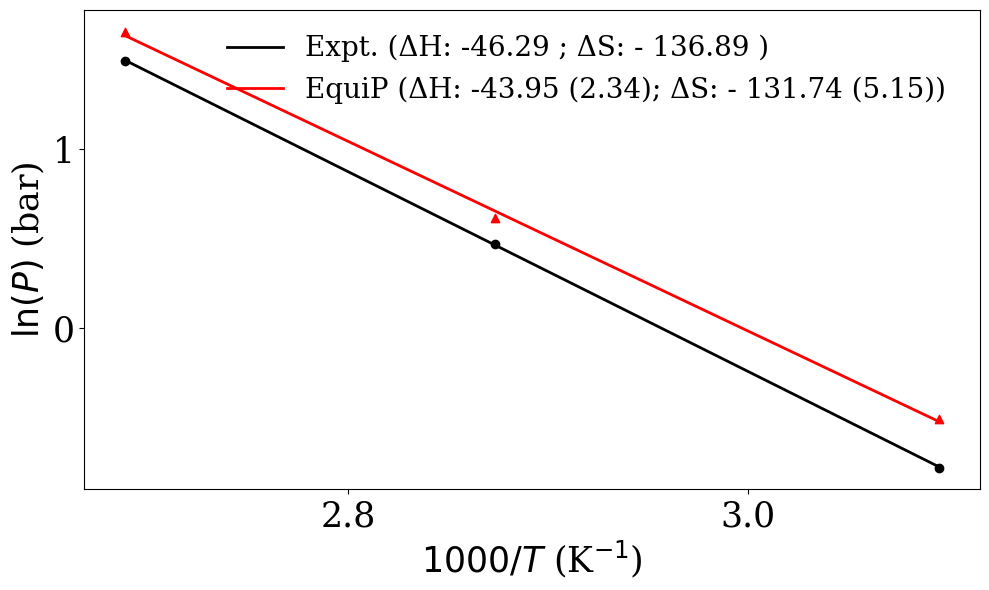

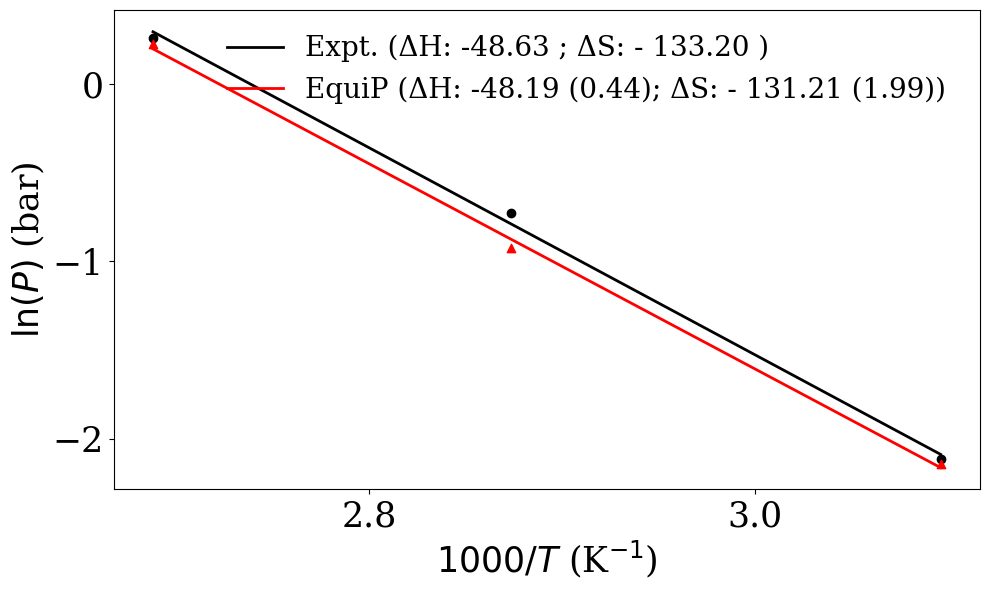

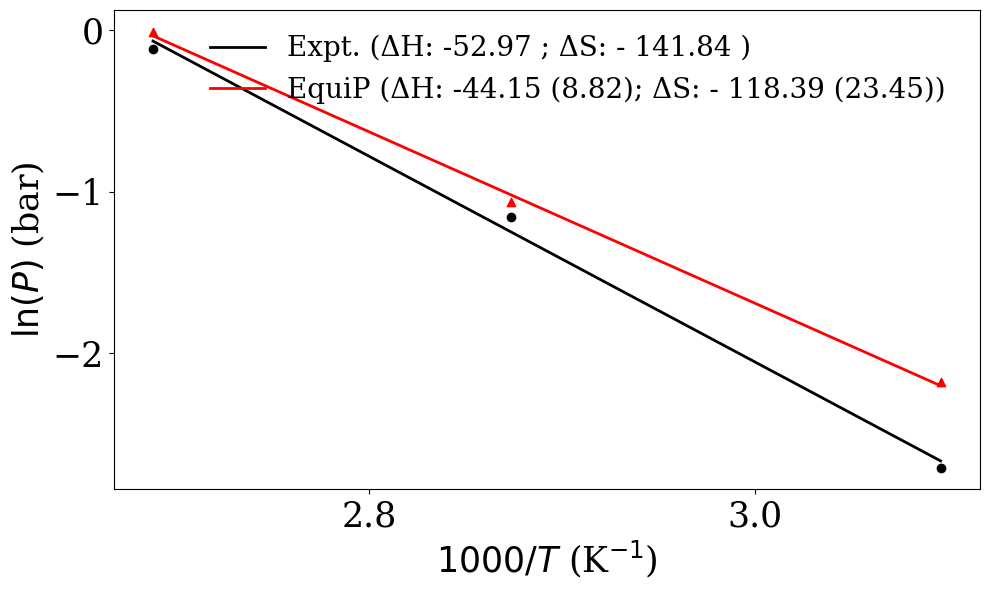

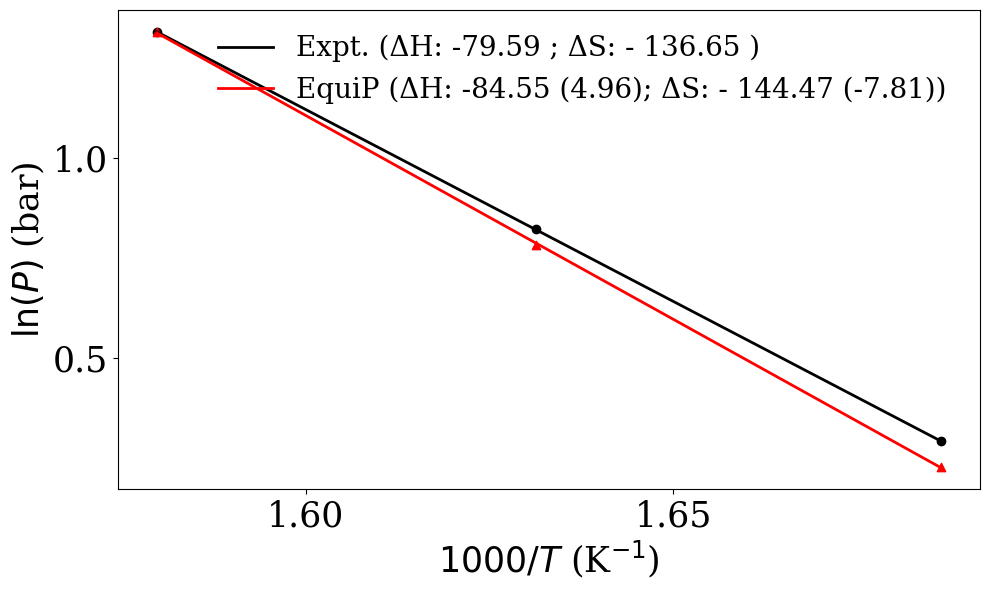

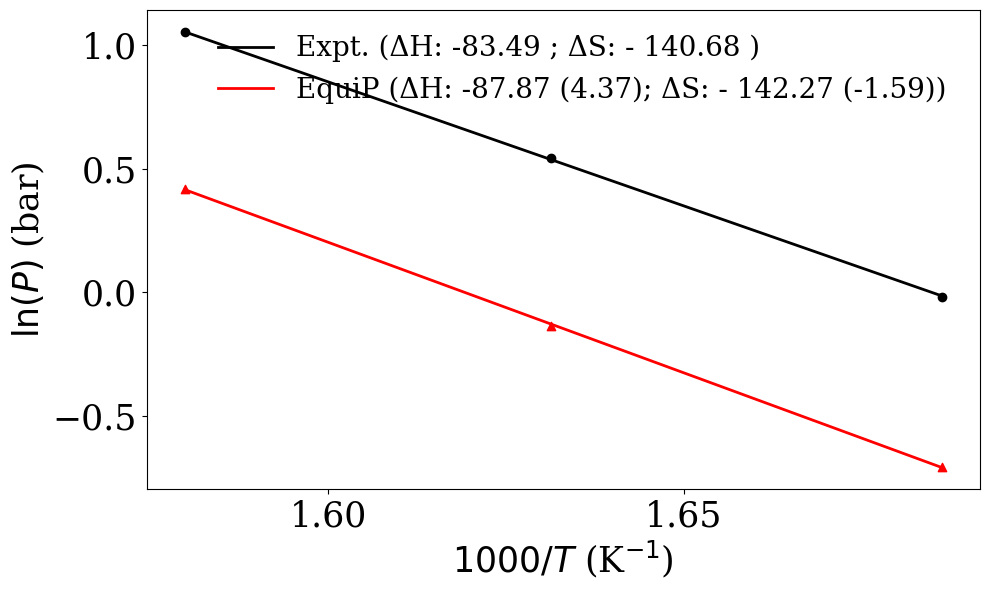

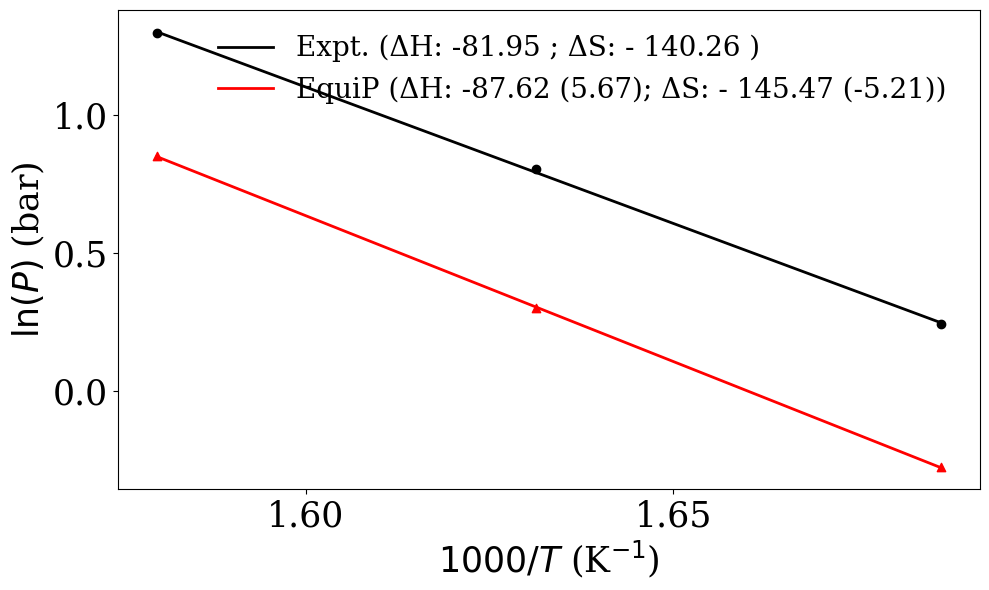

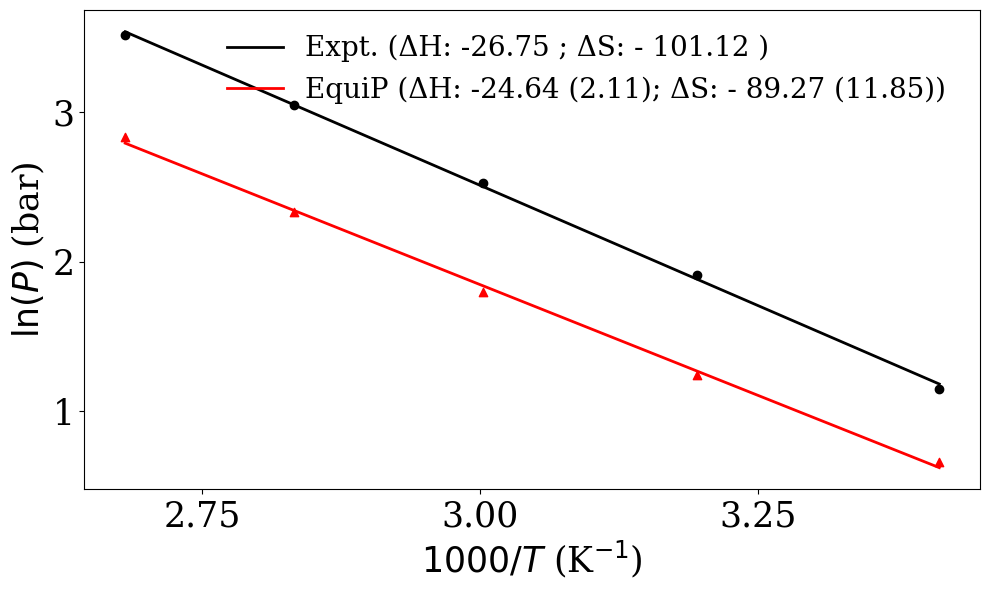

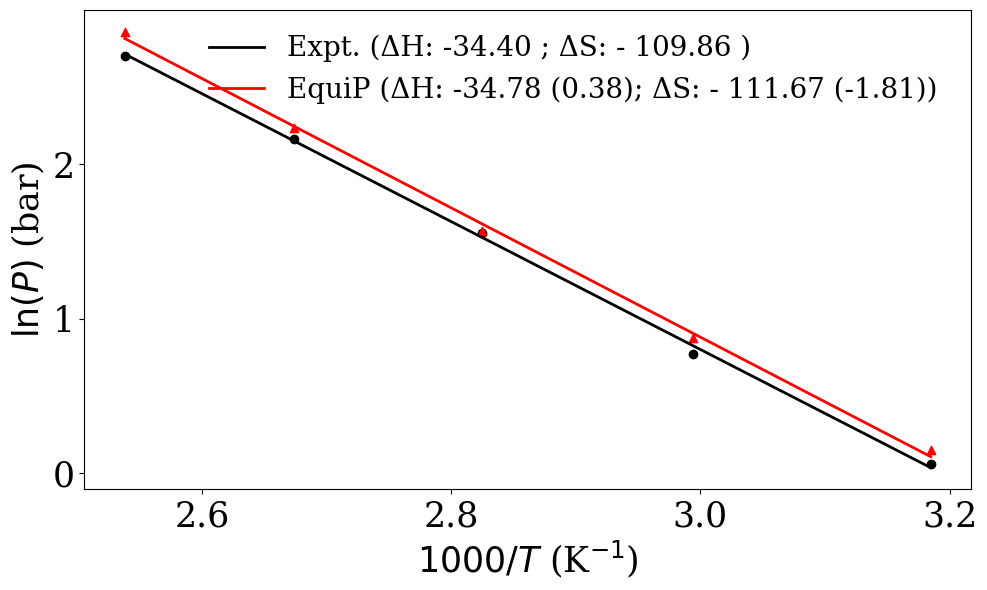

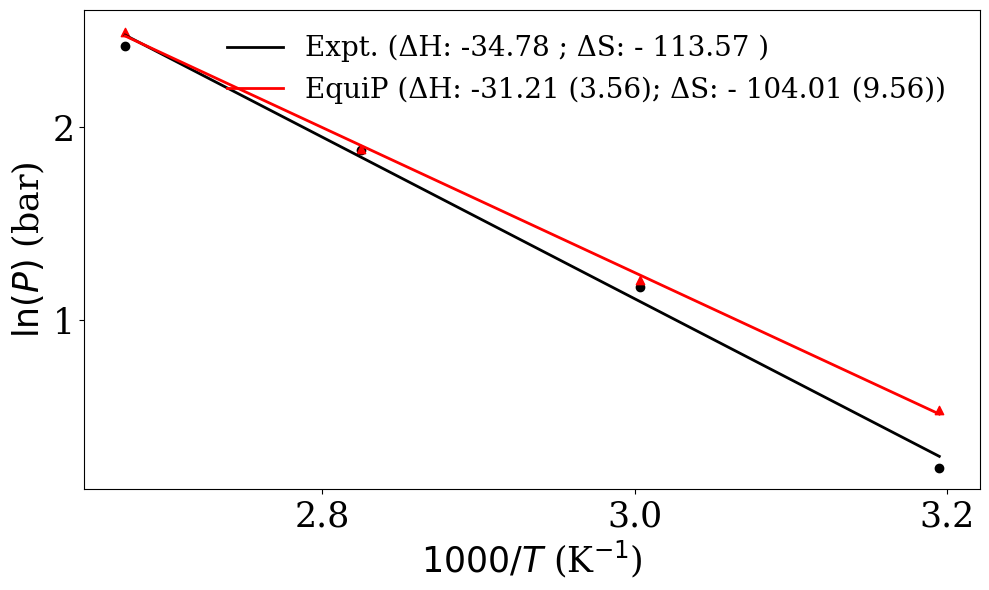

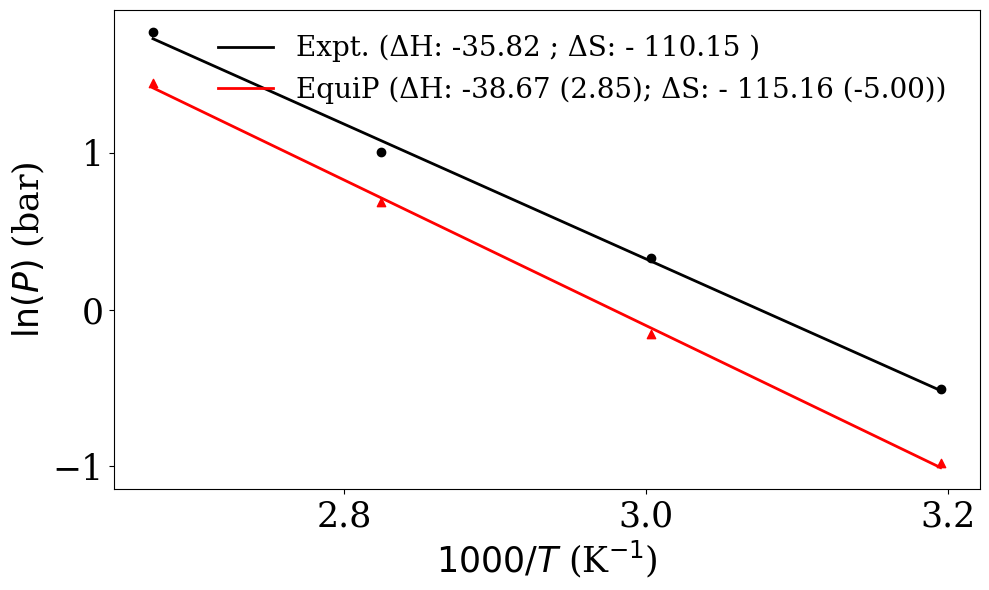

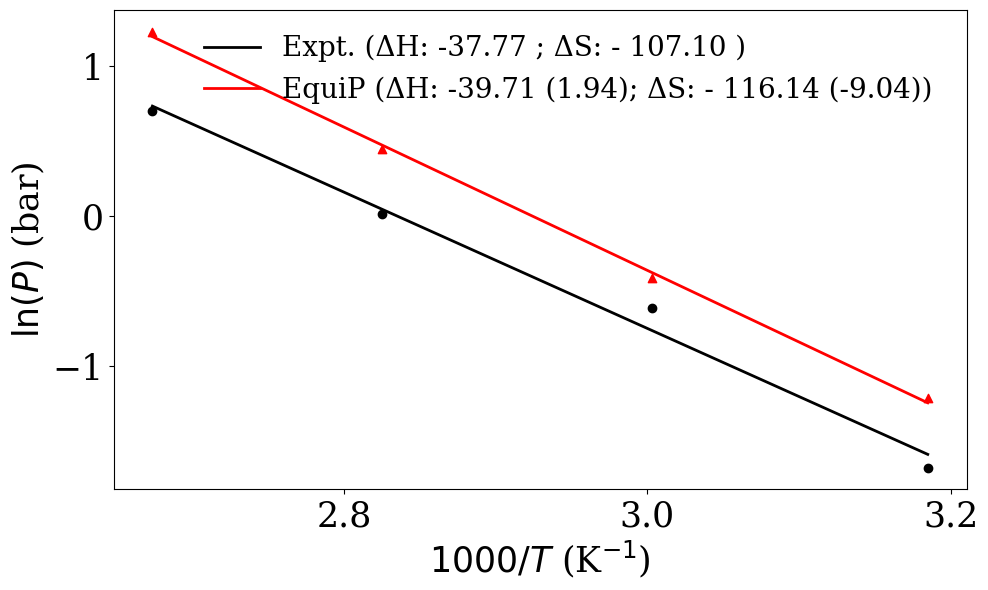

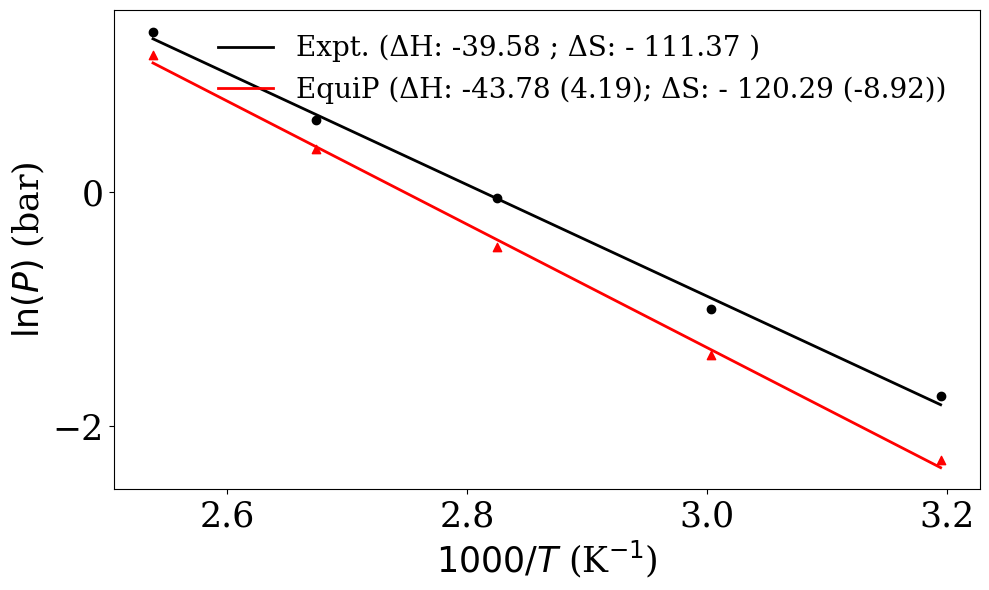

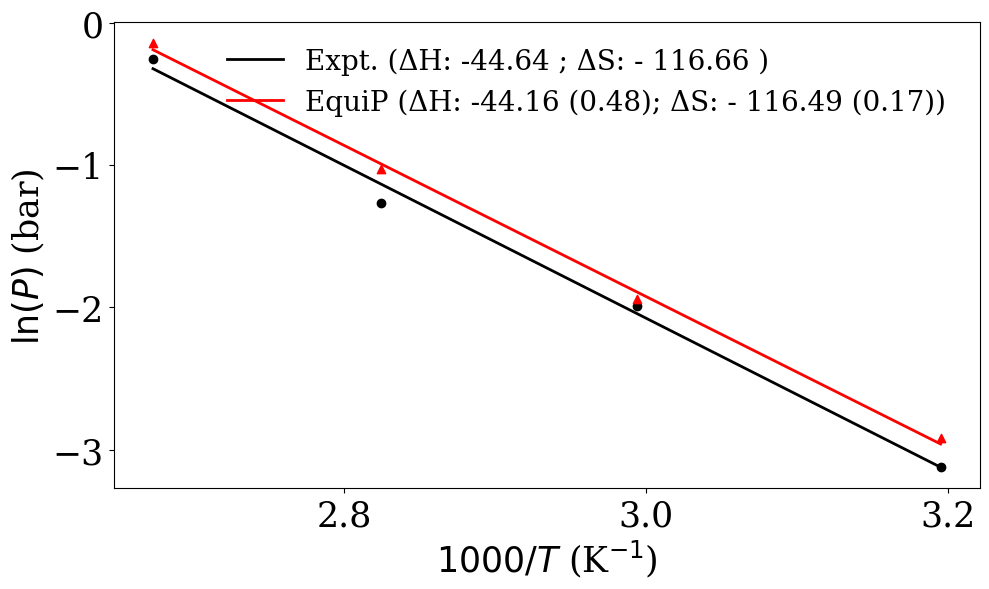

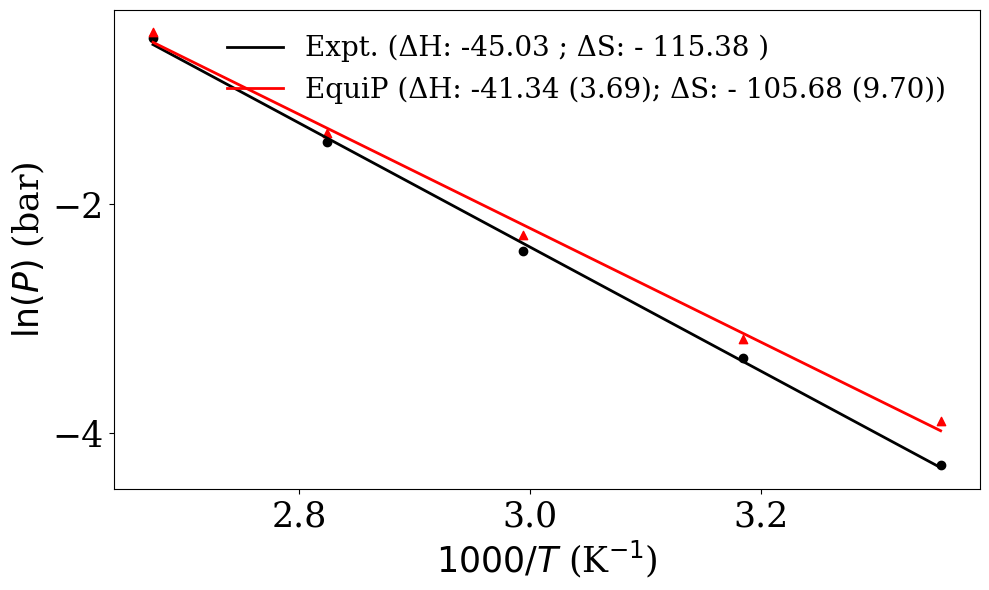

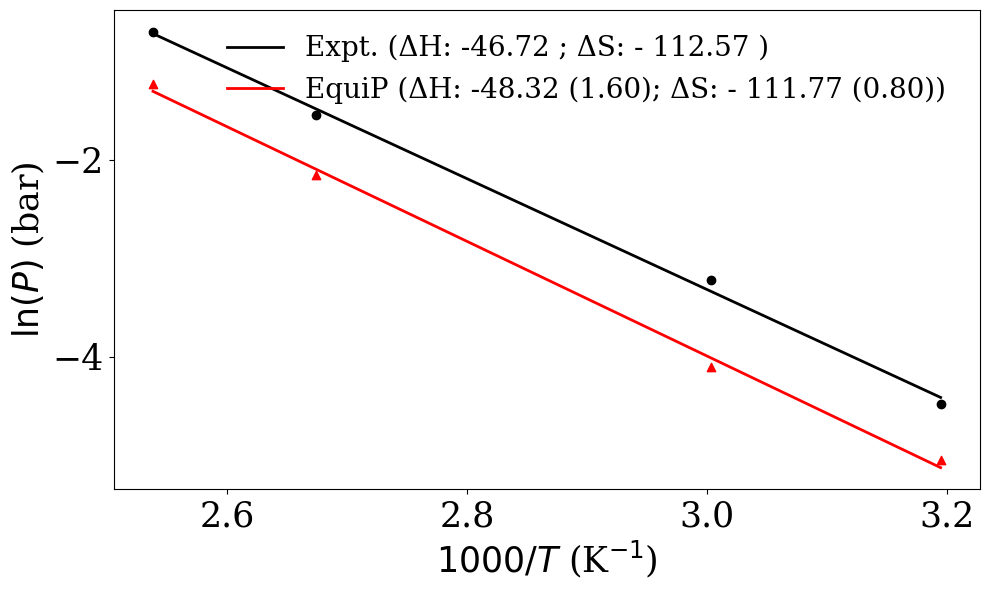

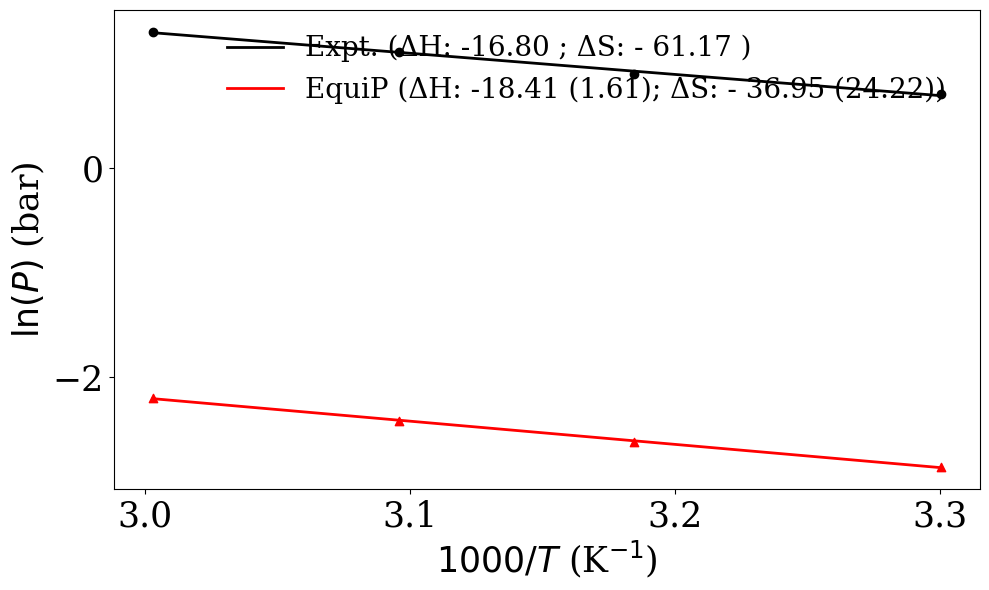

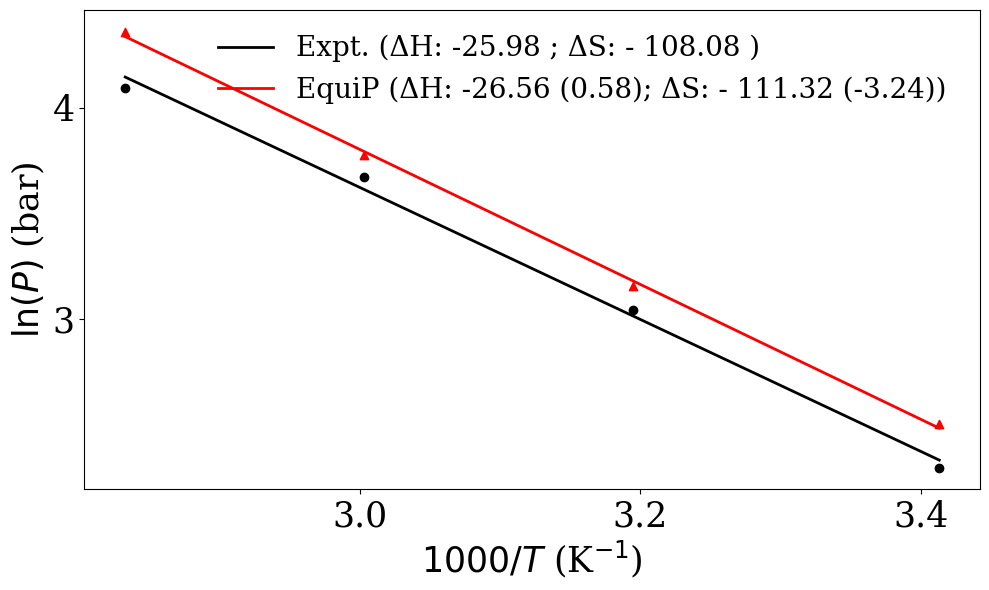

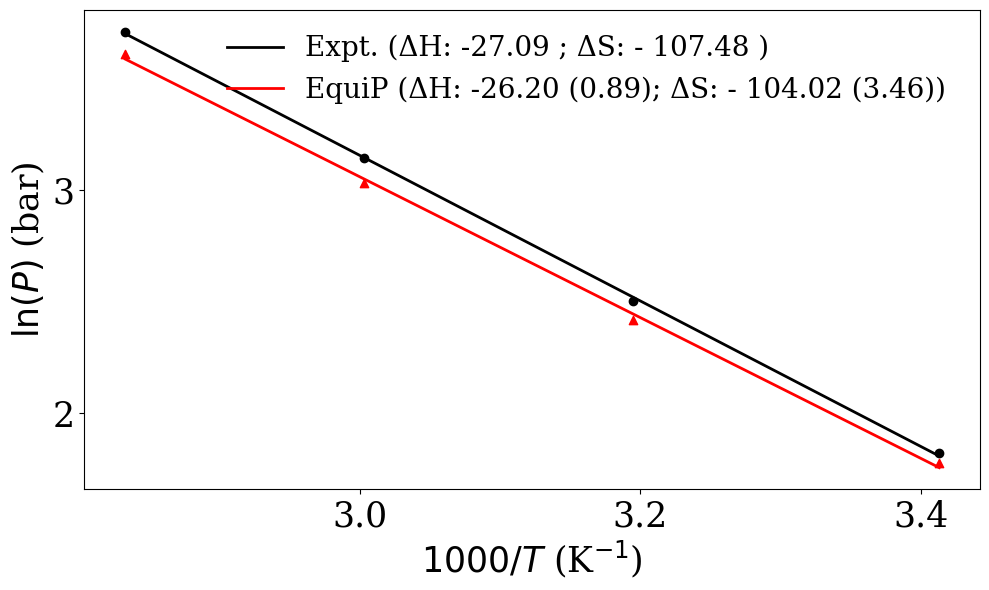

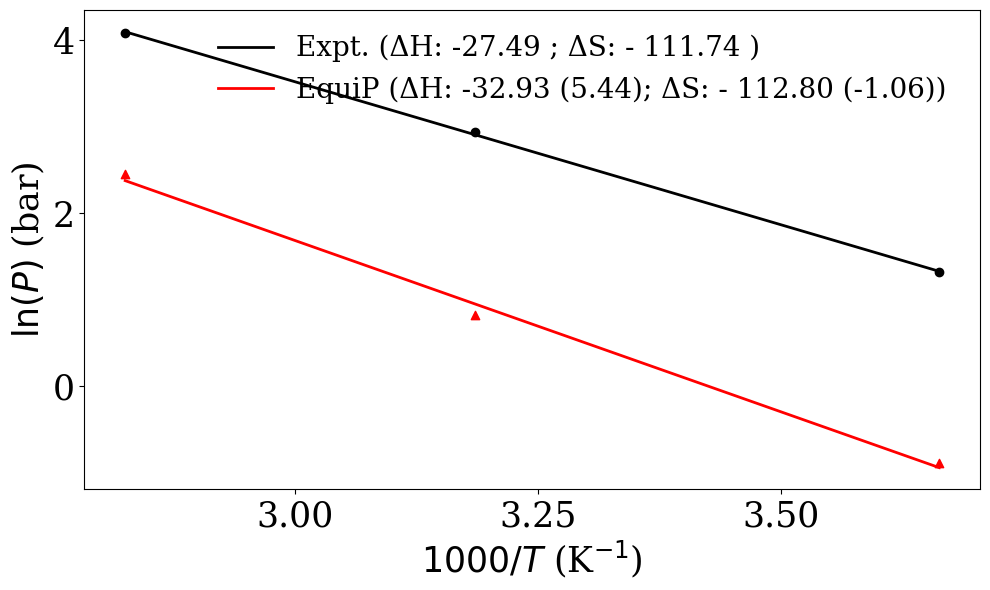

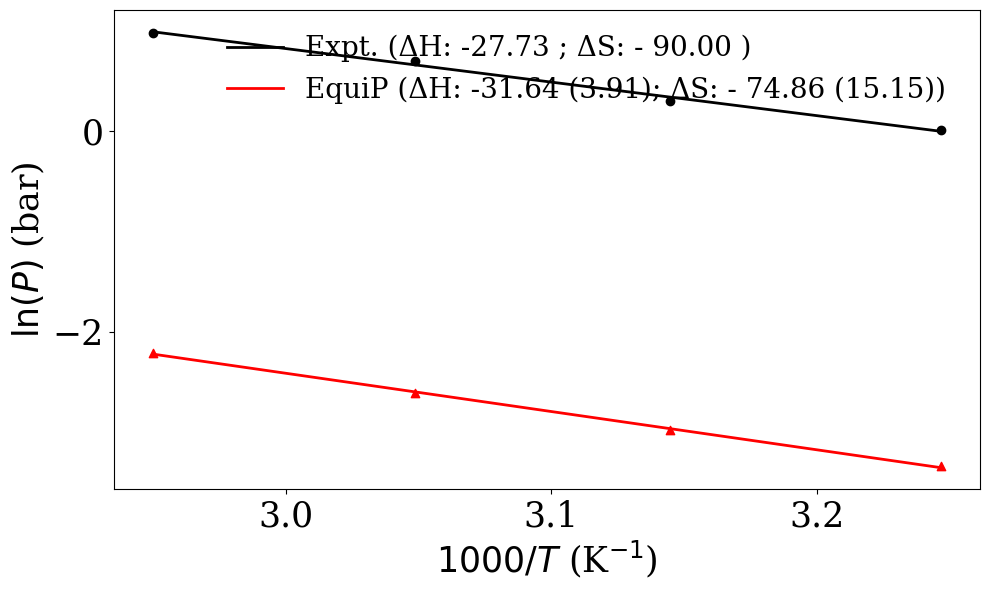

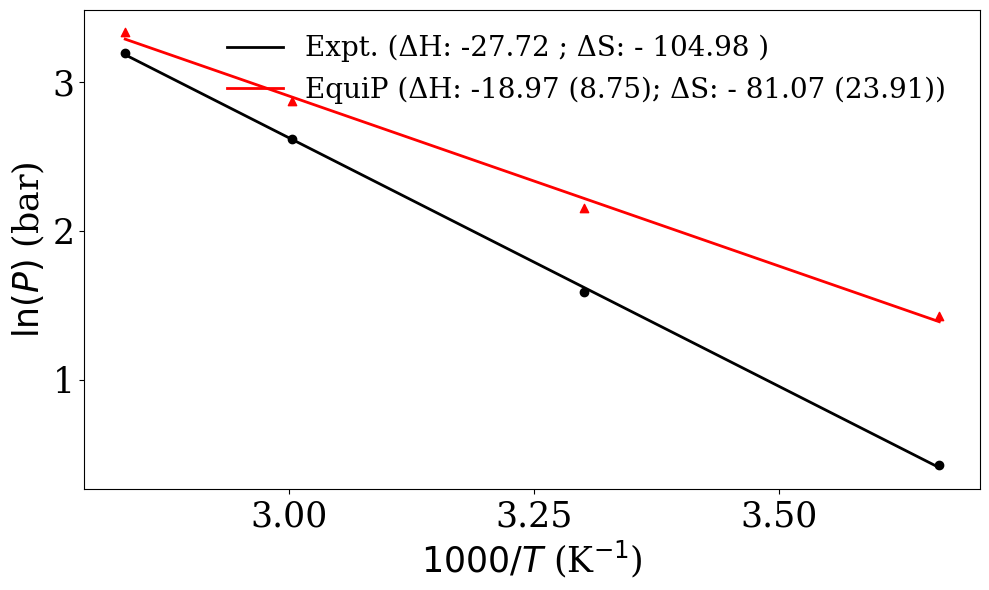

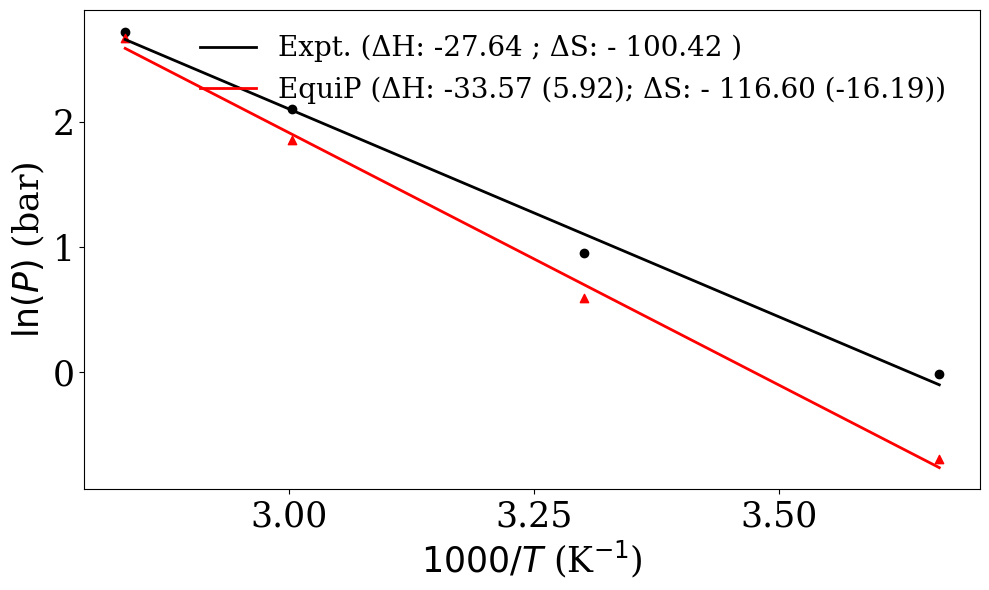

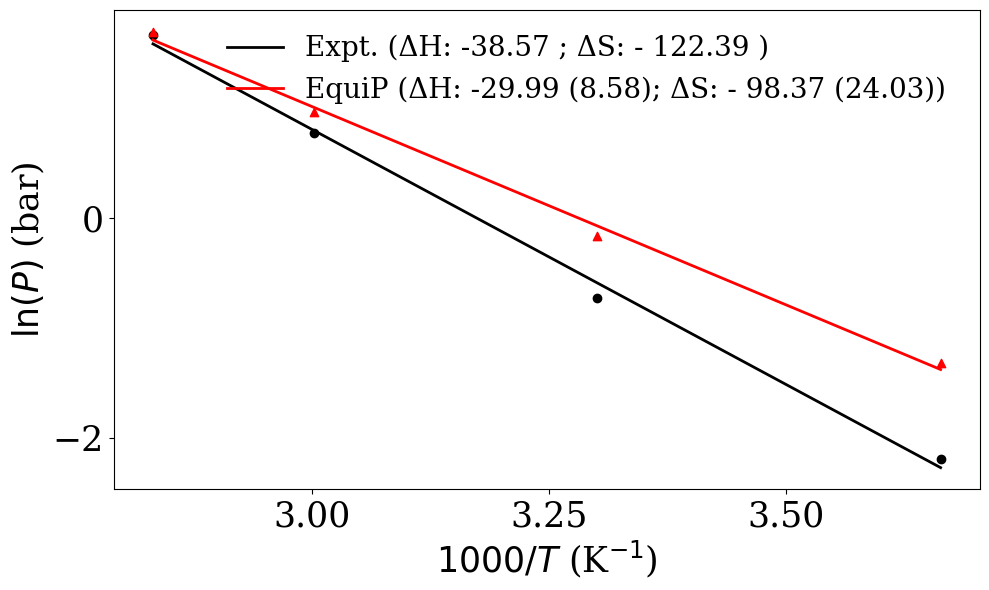

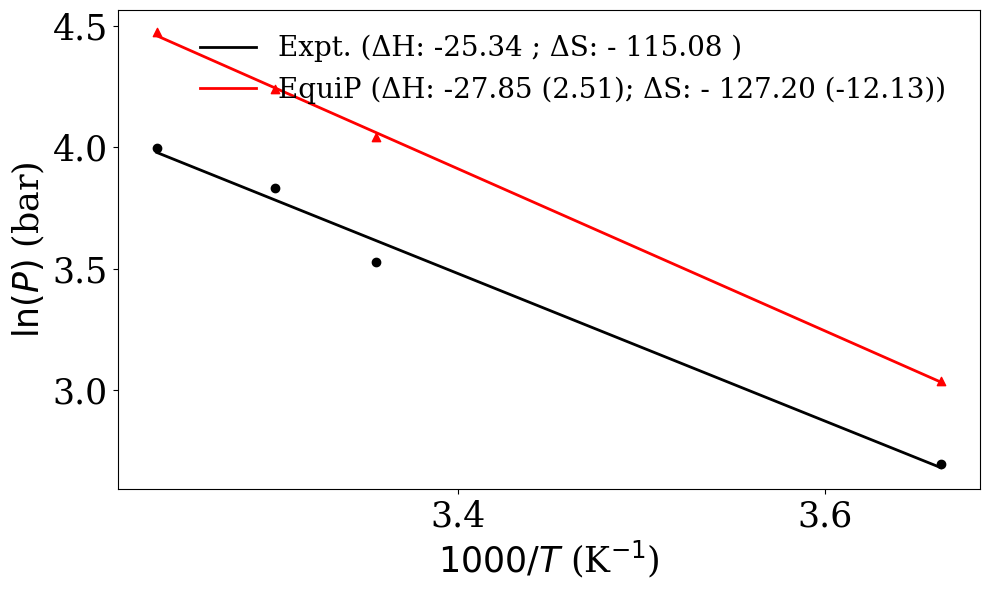

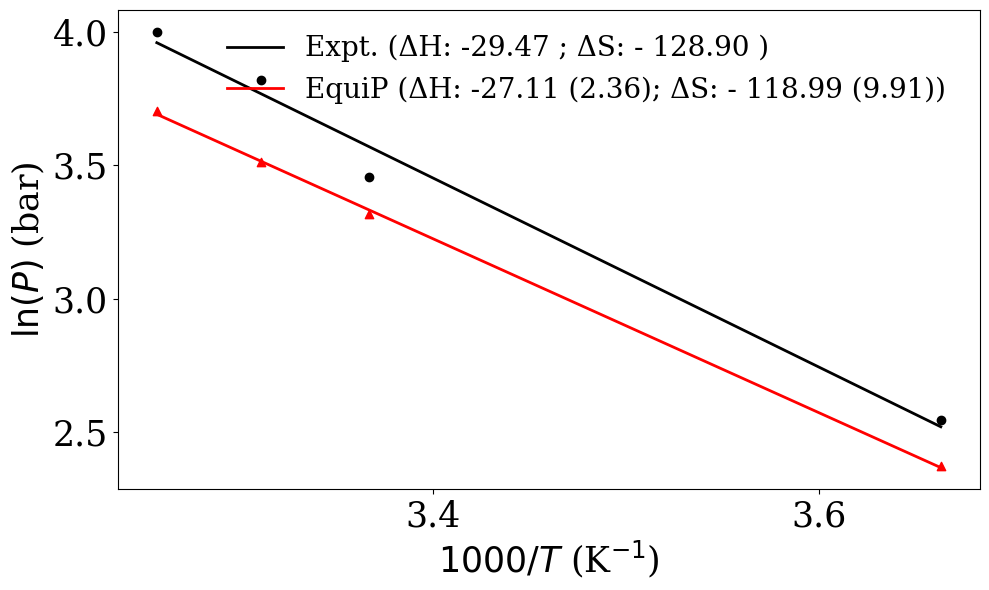

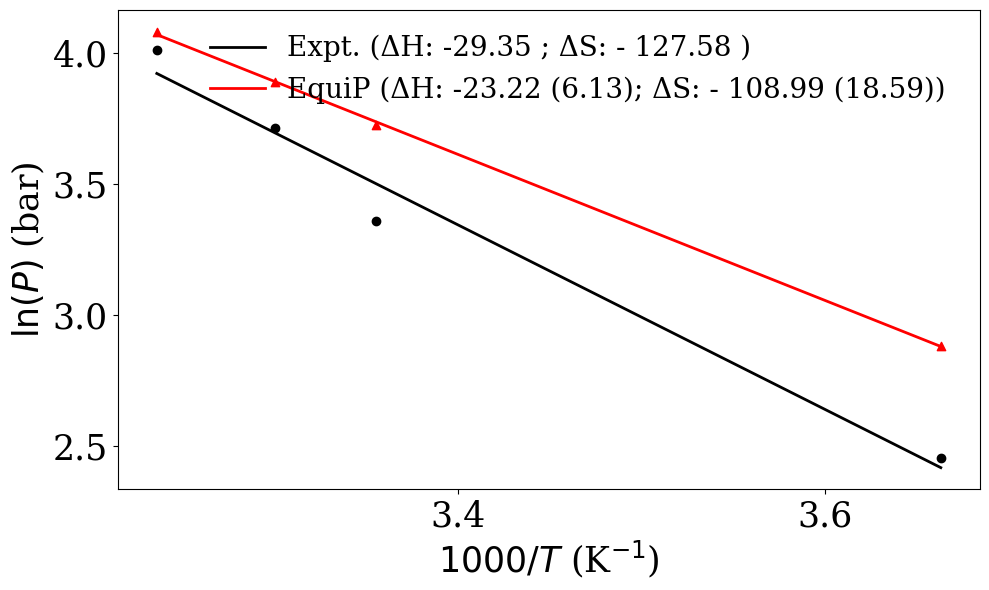

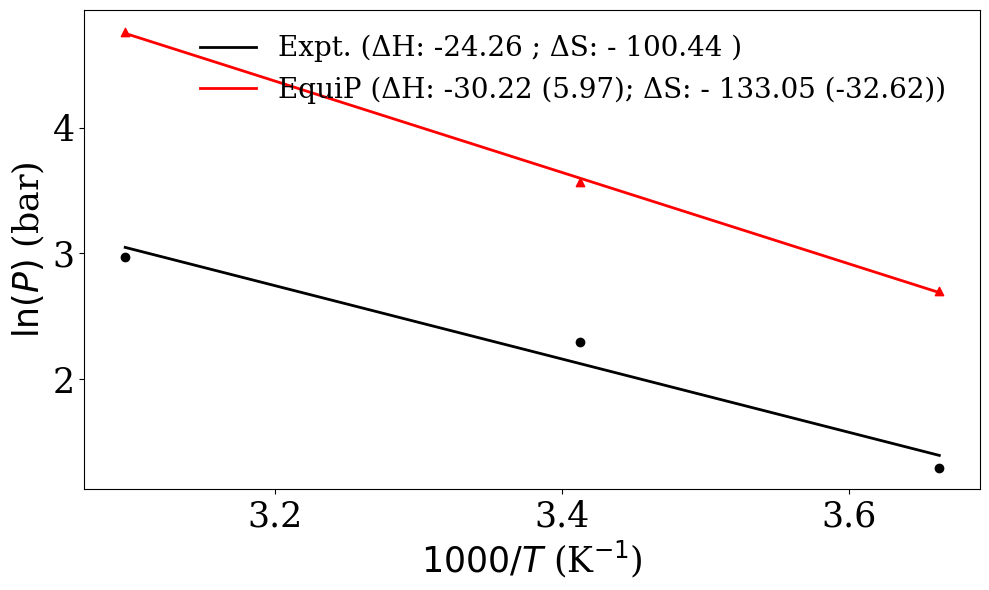

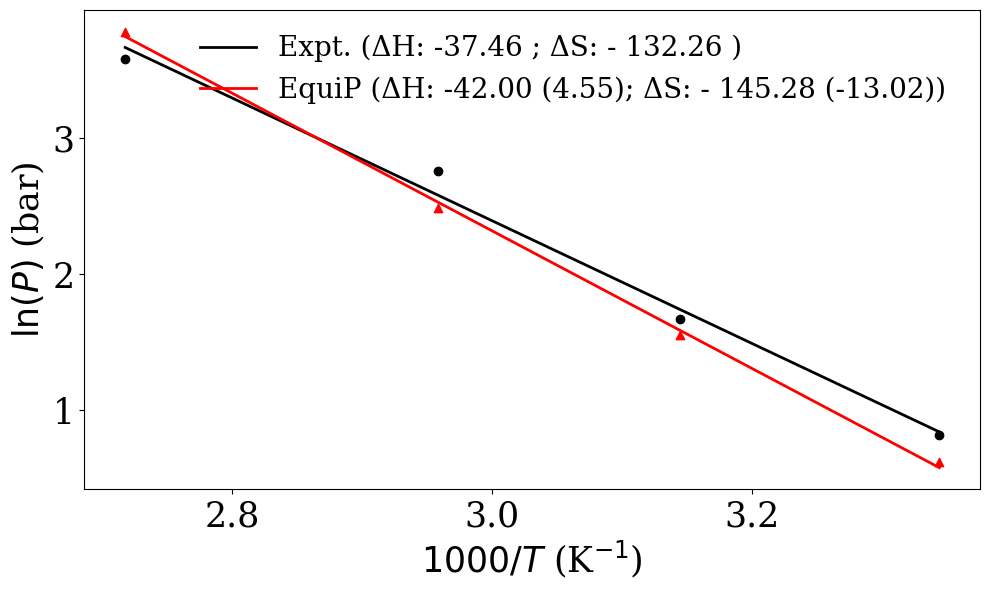

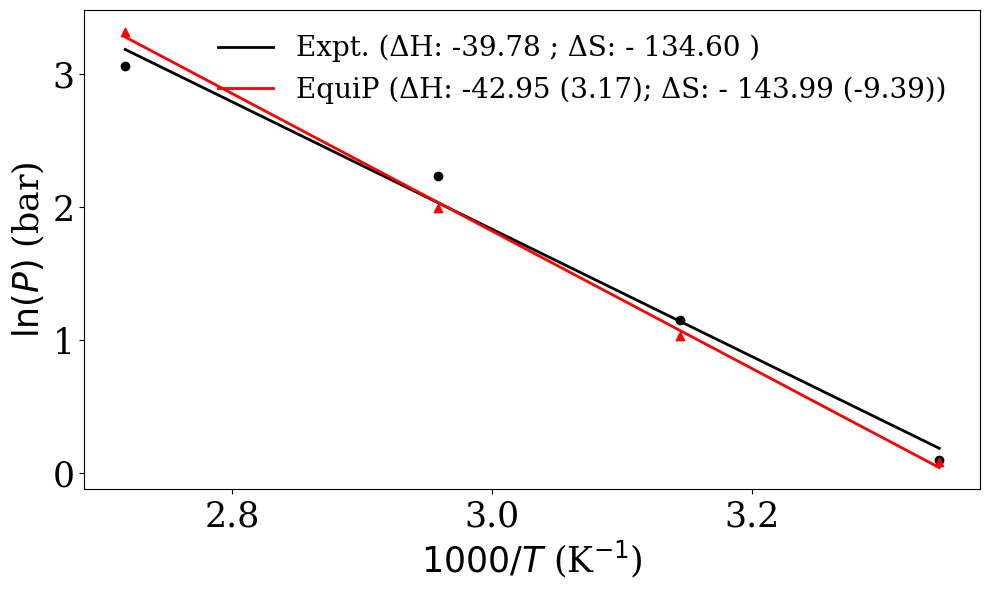

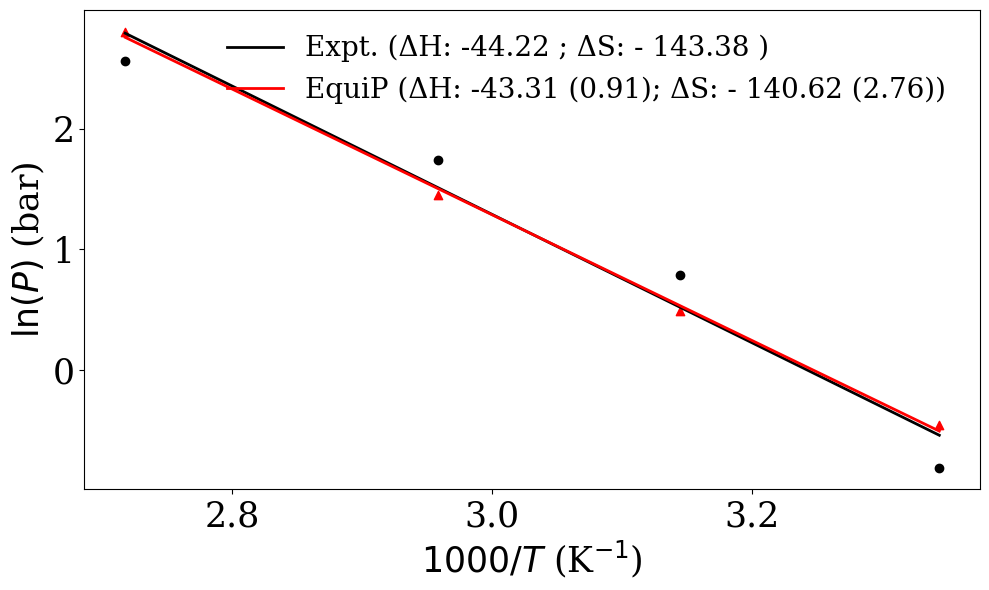

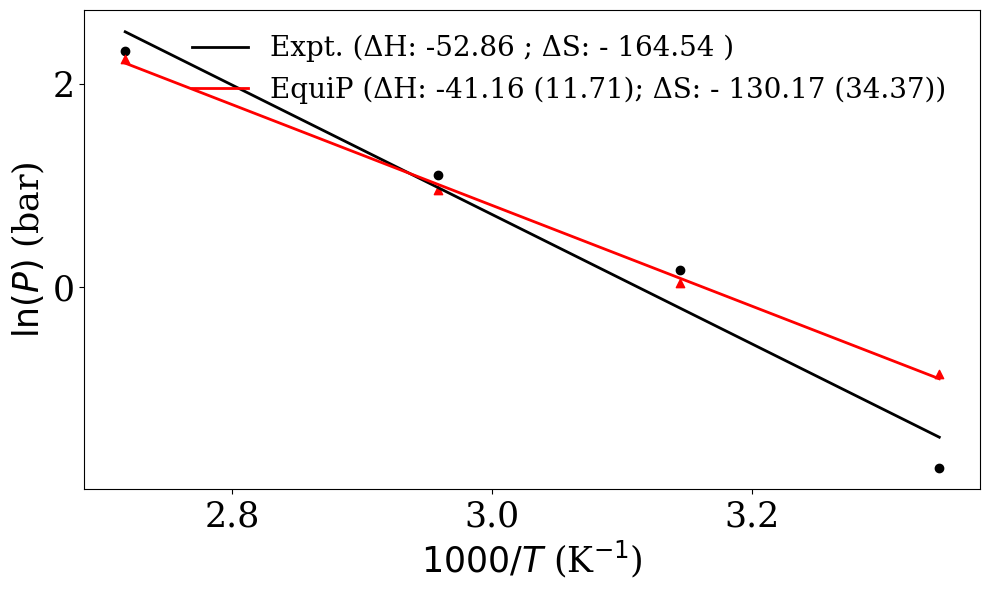

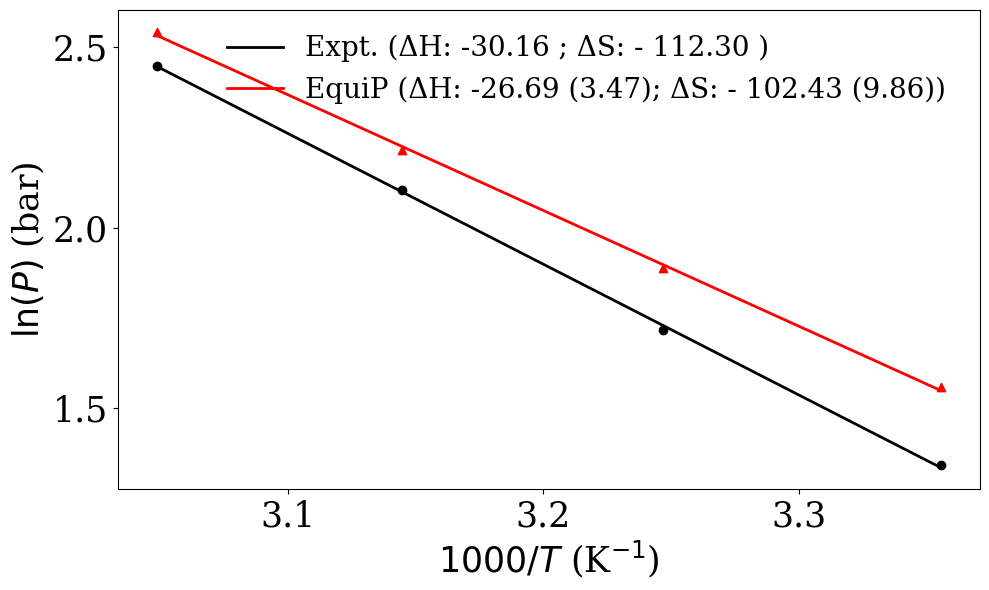

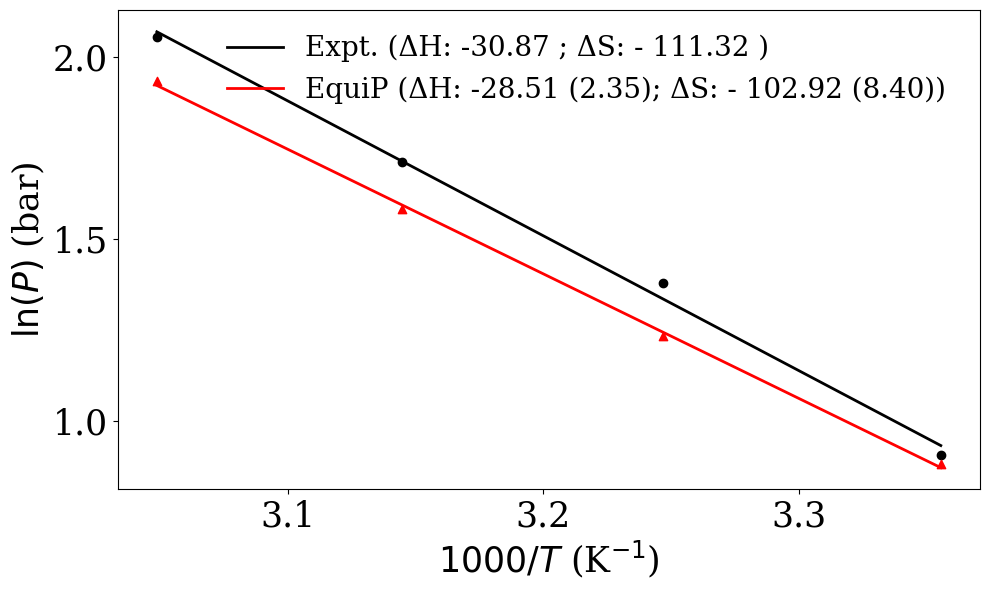

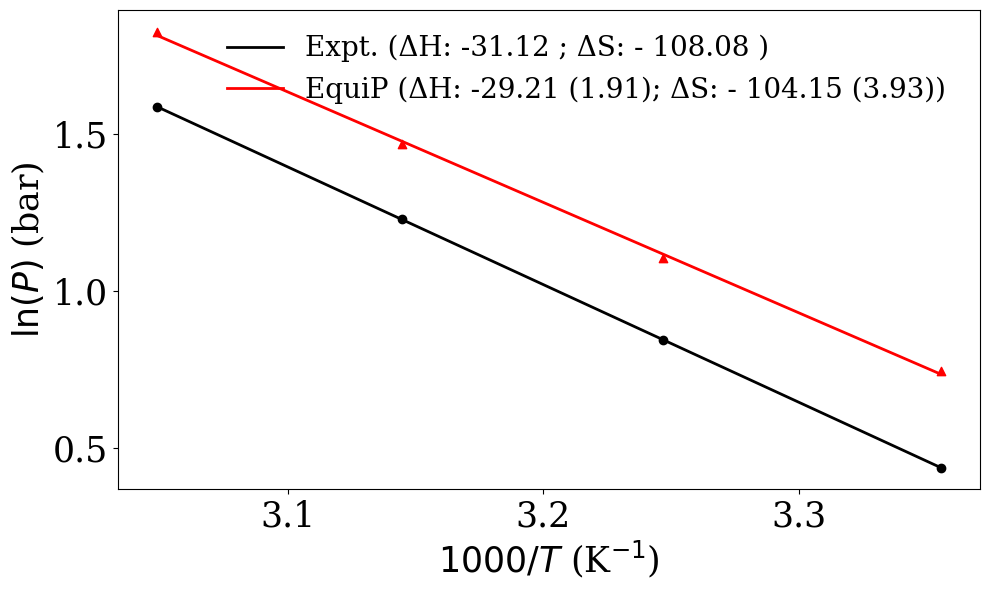

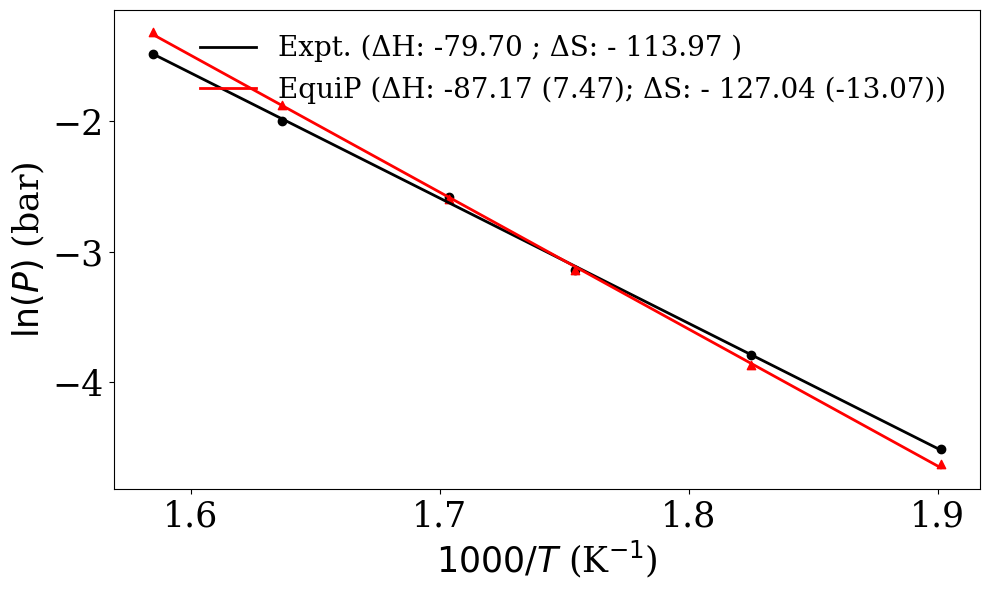

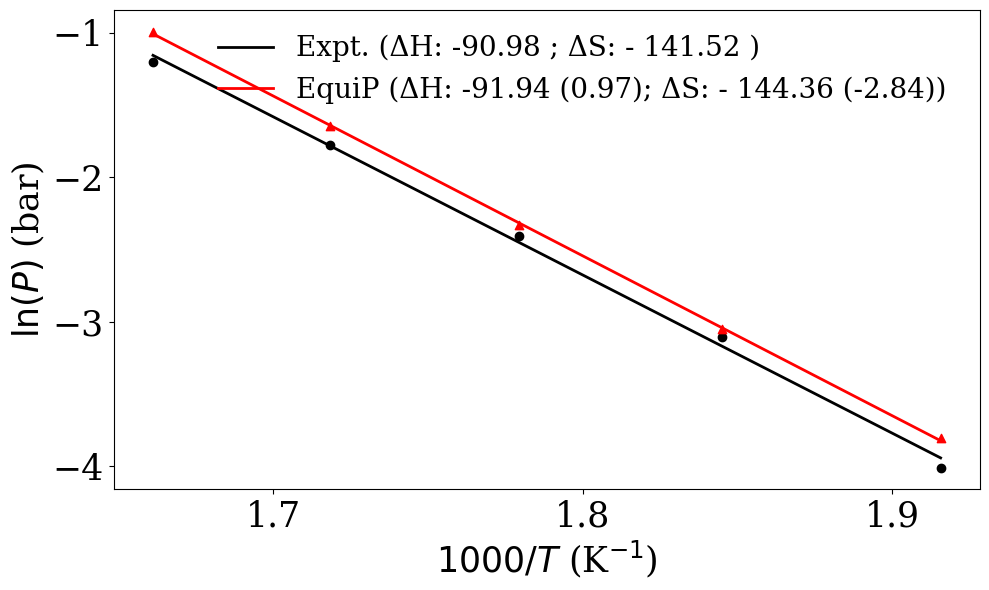

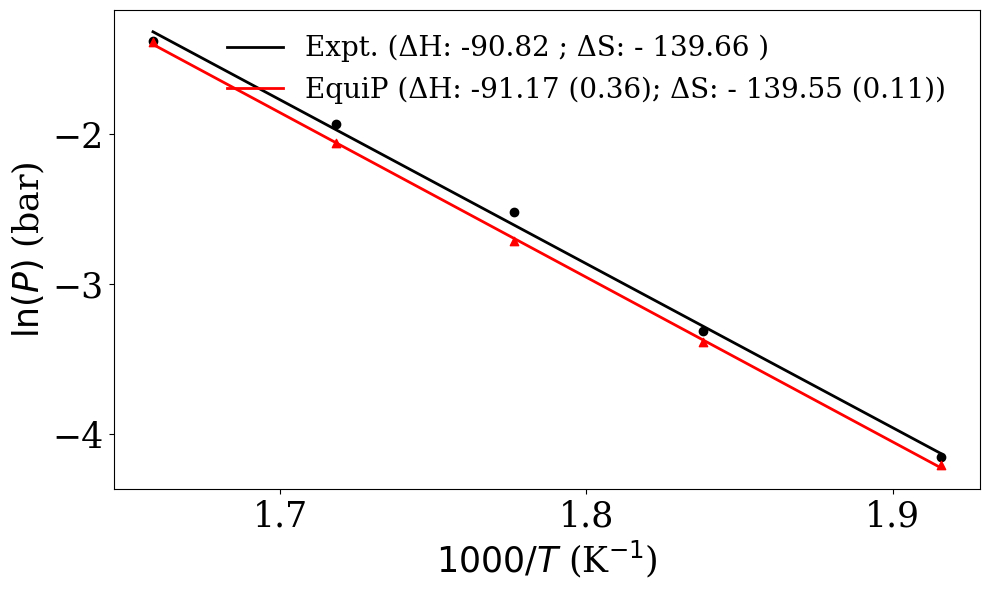

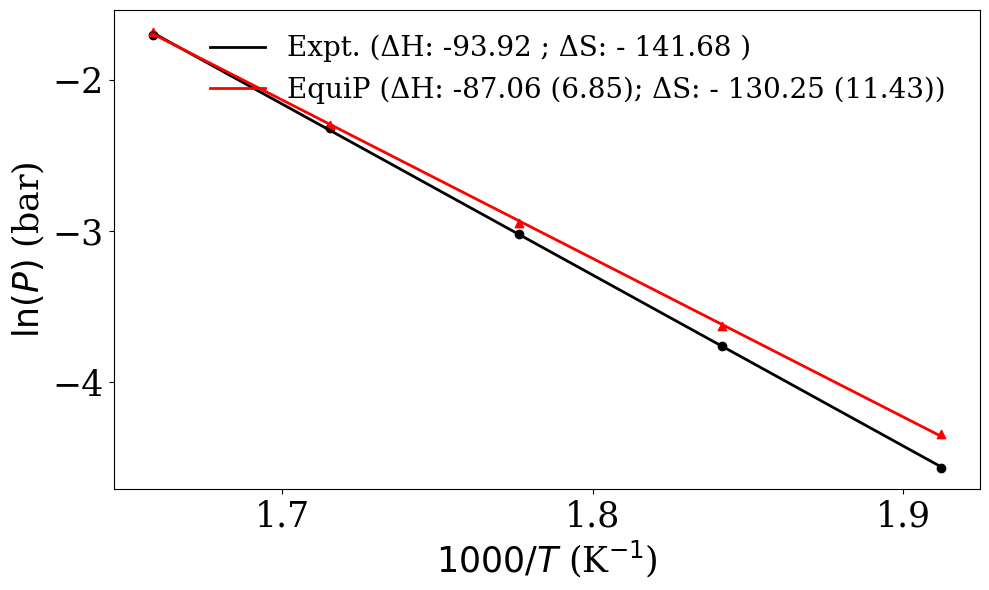

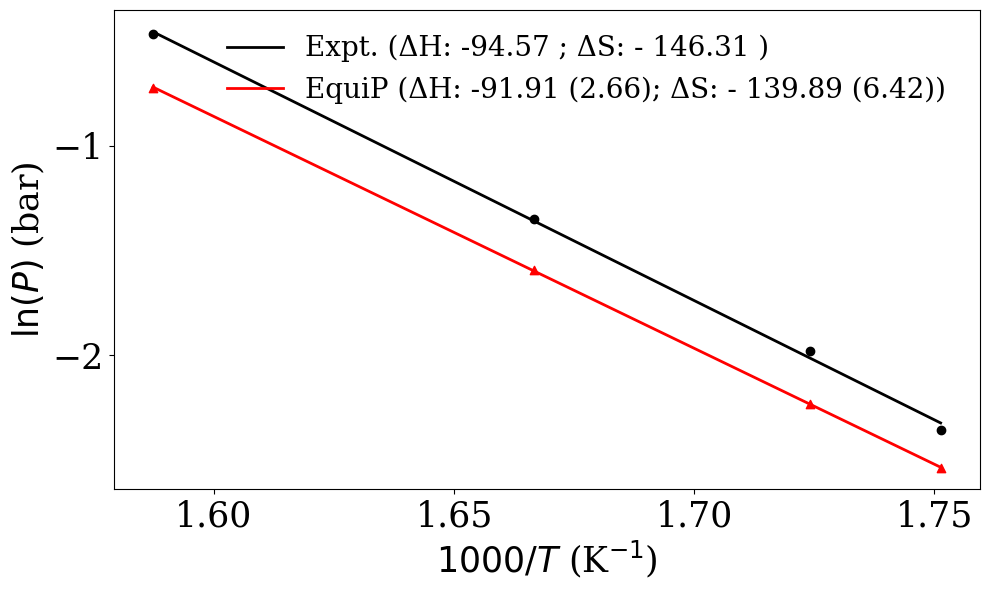

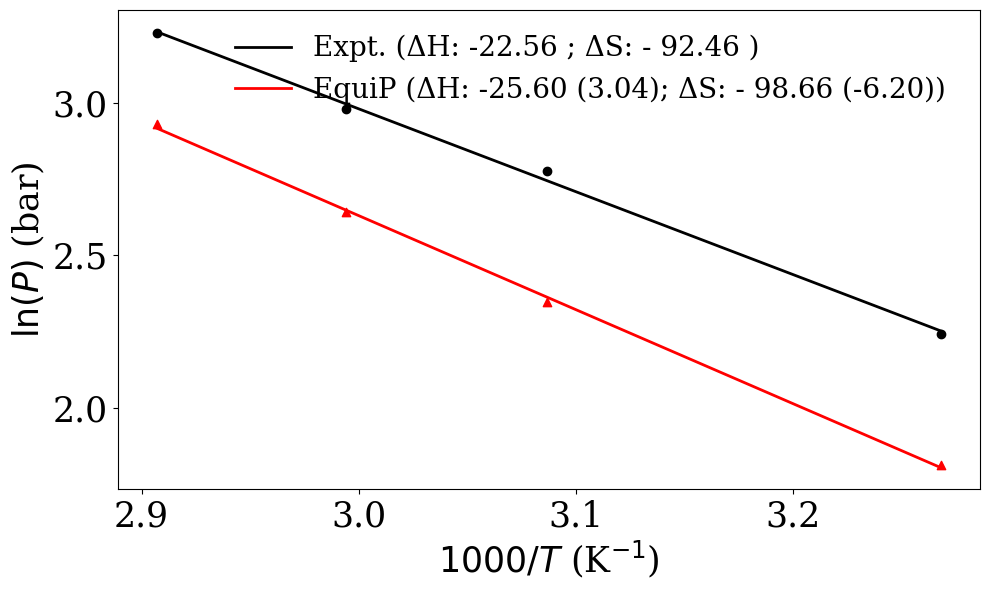

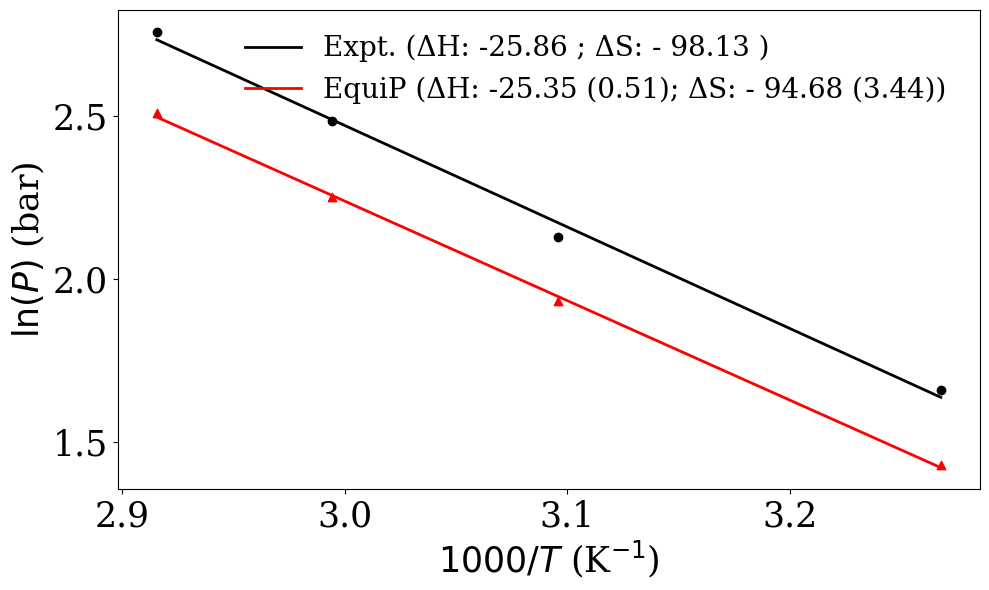

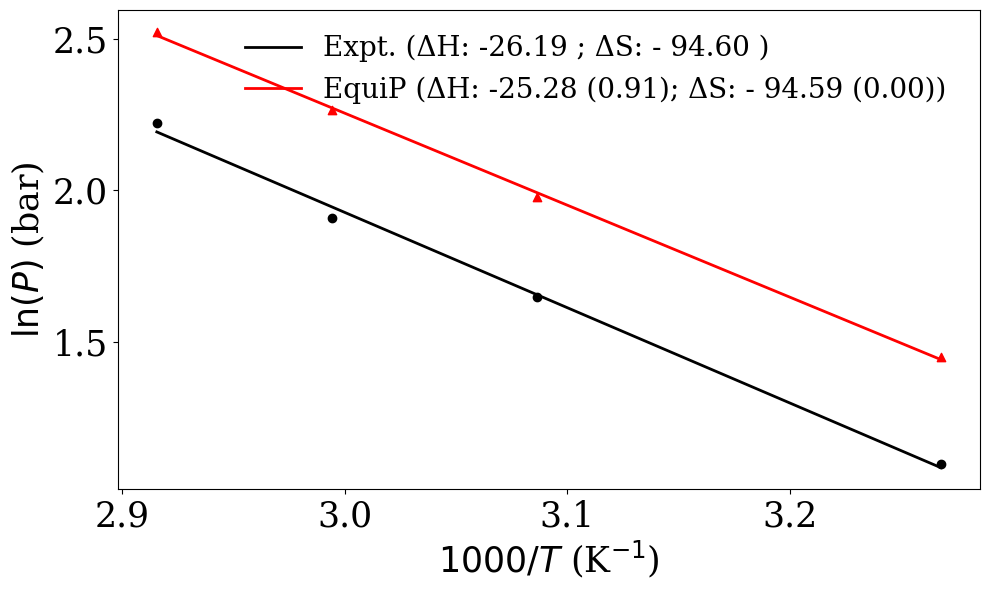

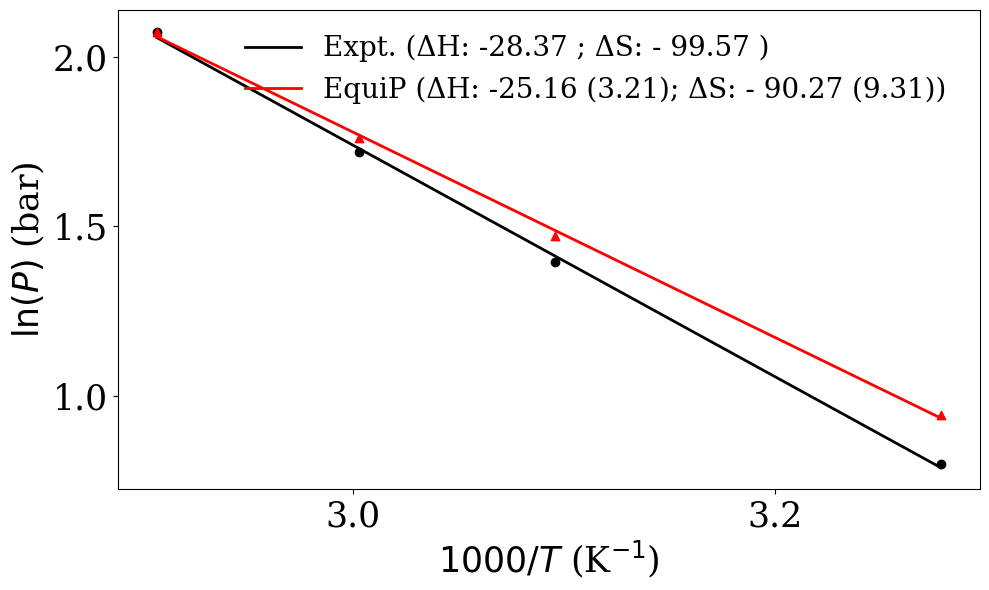

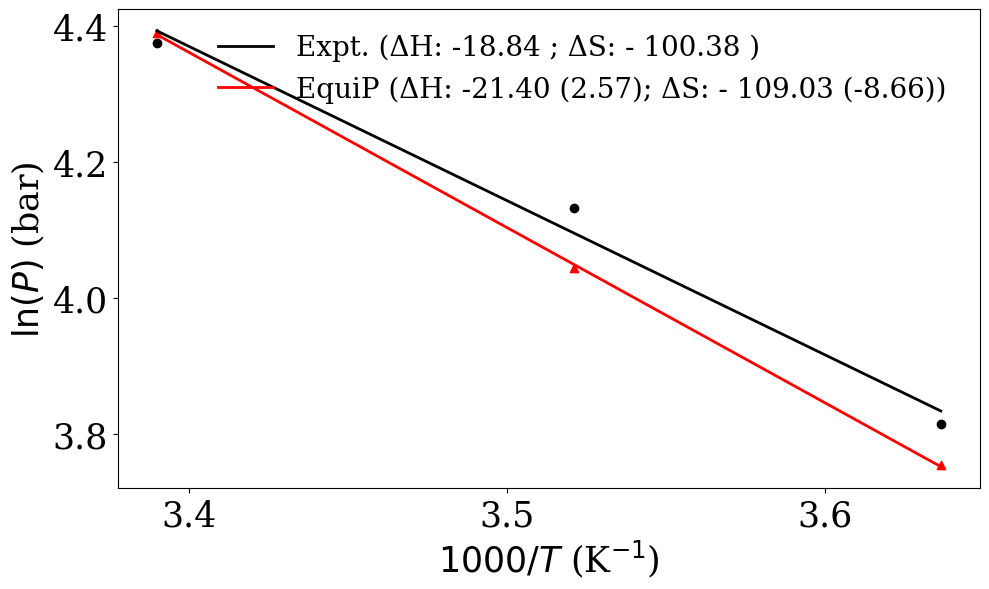

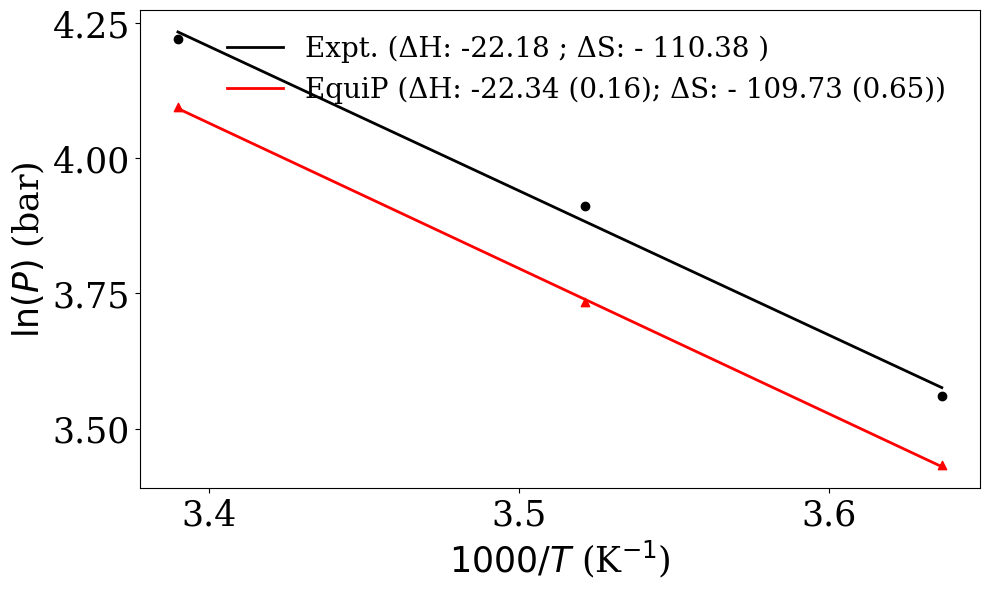

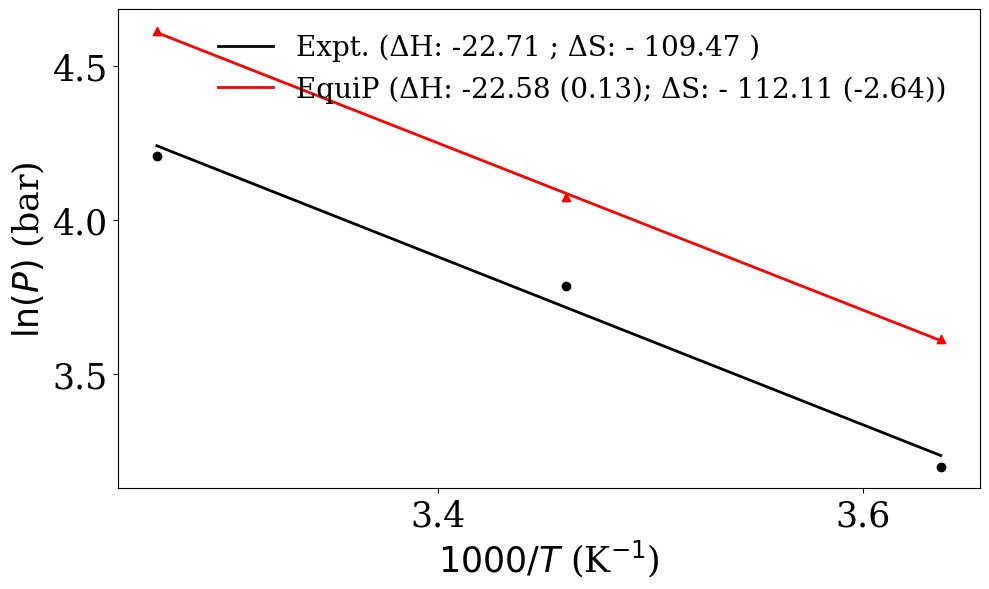

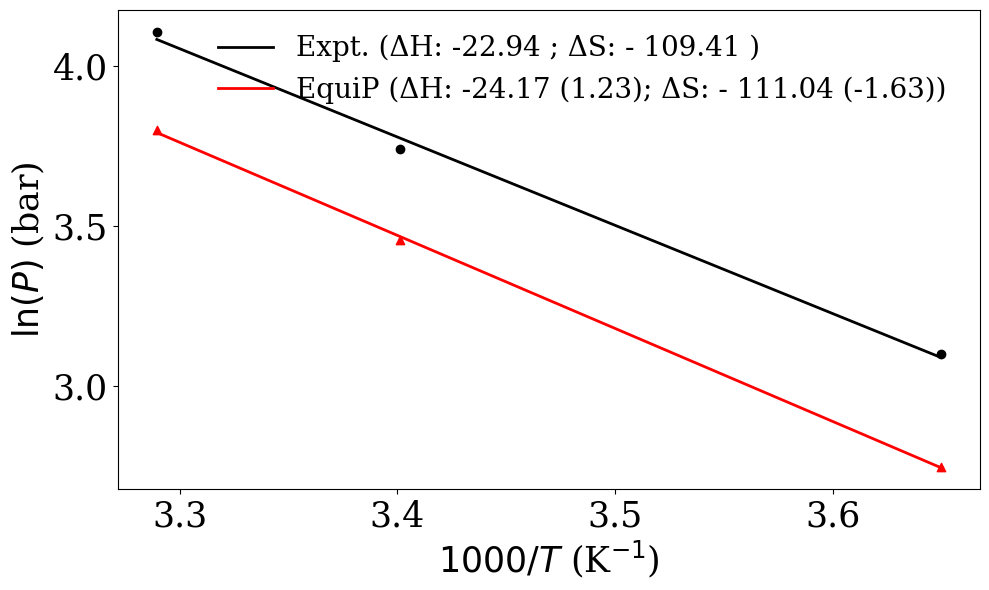

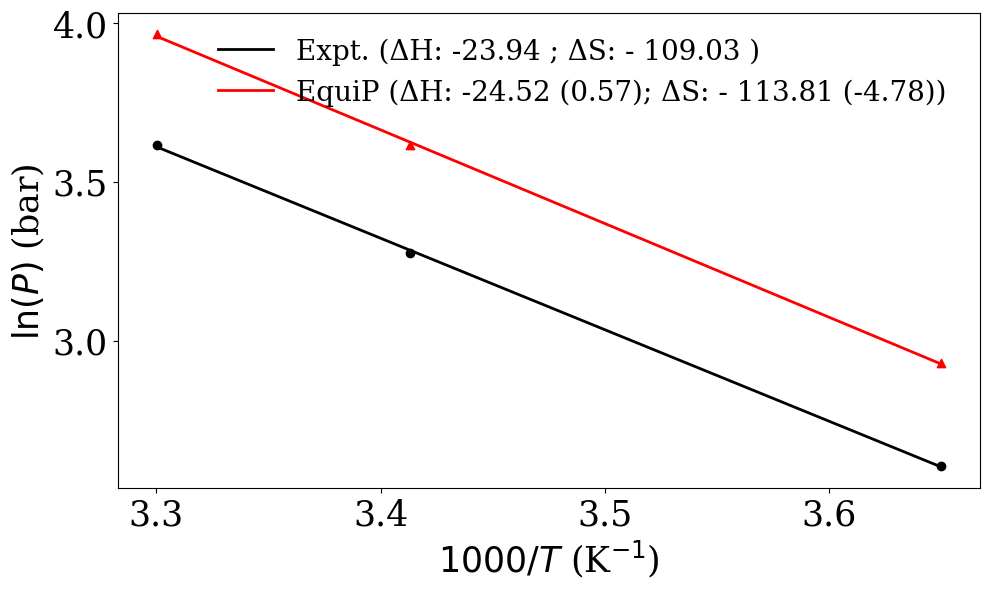

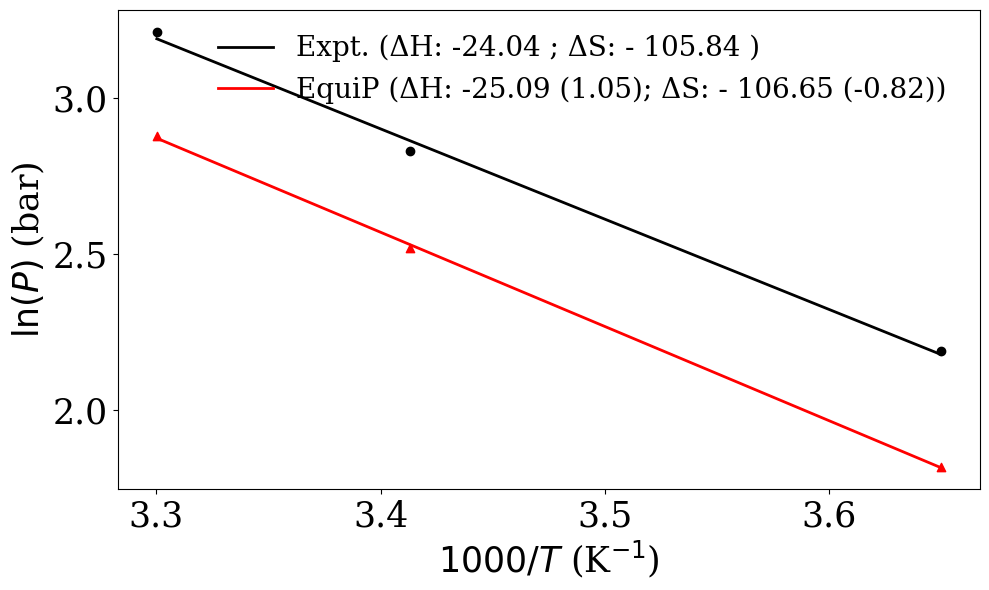

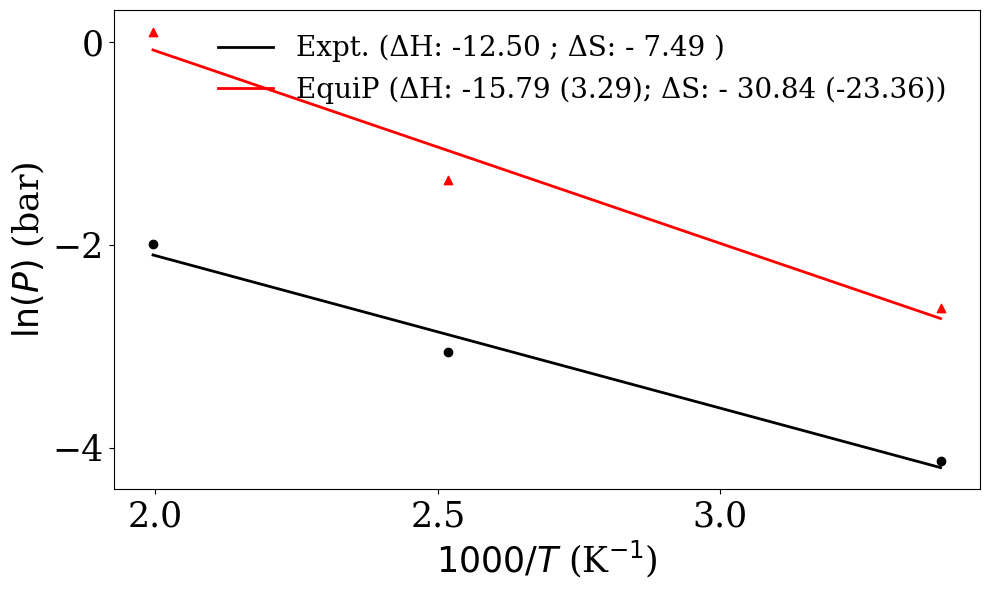

In [39]:
#Step 7: Leave-One-Composition-Out (LOCO) Analysis
# Iteratively removes one composition from training
# train model on n-1 compositions 
# Predicts Peq for removed composition using the rest of the data
# Compares predicted vs. experimental P–T relationships
# Estimates ΔH (enthalpy) and ΔS (entropy) via Van’t Hoff fits
# Plots are generated showing both experimental and model-predicted trends for each composition.
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

col1=['Temperature', 'CR',    
       'FIE',  'BM', 'HF', 'MV',  'Mass',
    'M-H_Bond', 'M-H_Eng',    'formation_H', 
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix']
dff = []
unique_entries = data.drop_duplicates(['composition_final'])
test=data
Va = pd.DataFrame()

for xx in range(0,len(unique_entries)):
    q=unique_entries[xx:xx+1]
    compostion = q['composition_final']
    com=compostion.values[0]
    TEST=data[(data["composition_final"]==com)]
    TRAIN= data.drop(TEST.index)

    X_train1 = TRAIN[col1]
    y_train1 = TRAIN["Ln(P)_Mpa"]

    #Input and Target
    X_test1 = TEST[col1]
    y_test1 = TEST["Ln(P)_Mpa"]
    


    clf1=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.1)
    clf1.fit(X_train1, y_train1)
    TEST['ML_KRR']=clf1.predict(X_test1)

    plt.figure(figsize=(10,6))
    plt.rcParams['font.family'] = 'Serif'
    plt.locator_params(nbins=4)
    plt.xticks(fontsize=25,)
    plt.yticks(fontsize=25)
    slope, intercept, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])))
    sl1= slope*8.314
    in1= intercept*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])), marker='o',color='black')
    plt.plot((1000/(TEST['Temperature_1'])), slope*(1000/(TEST['Temperature_1'])) + intercept, 'ko-', linewidth=2, markersize=0, color='black', label=f'Expt. (ΔH: {sl1:.2f} ; ΔS: - {in1:.2f} )')
    TEST['Exp_Entalpy'] =sl1
    TEST['Exp_Entropy'] =in1
    slope1, intercept1, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])))
    sl2= slope1*8.314
    in2= intercept1*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])),marker='^',color='red')
    plt.plot(1000/(TEST['Temperature_1']), slope1*(1000/(TEST['Temperature_1'])) + intercept1, 'r^-', linewidth=2, markersize=0, label=f'EquiP (ΔH: {sl2:.2f} ({np.abs(np.abs(sl1)-np.abs(sl2)):.2f}); ΔS: - {in2:.2f} ({in1-in2:.2f})) ')
    TEST['ML_Entalpy'] =sl2
    TEST['ML_Entropy'] =in2
    plt.xlabel(r'$1000/T$ (K$^{-1}$)', fontsize=25)
    plt.ylabel(r'$\ln(P)$ (bar)', fontsize=25)
    plt.legend(loc="upper right",frameon=False,fontsize=20)
    plt.tight_layout()
    plt.show()


In [40]:
#Step 8: SHAP (Feature Importance) Analysis
#Compute SHAP values to explain model predictions
#Generate SHAP summary plots and bar plots
#Rank features by mean absolute SHAP value (importance)
#This provides insight into which physical or chemical descriptors most strongly influence equilibrium pressure

import shap
# SHAP Explainer
model=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.1)
model.fit(X_train, y_train)
explainer = shap.KernelExplainer(model.predict,X_train)
shap_values = explainer(X_test)


Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/59 [00:00<?, ?it/s]

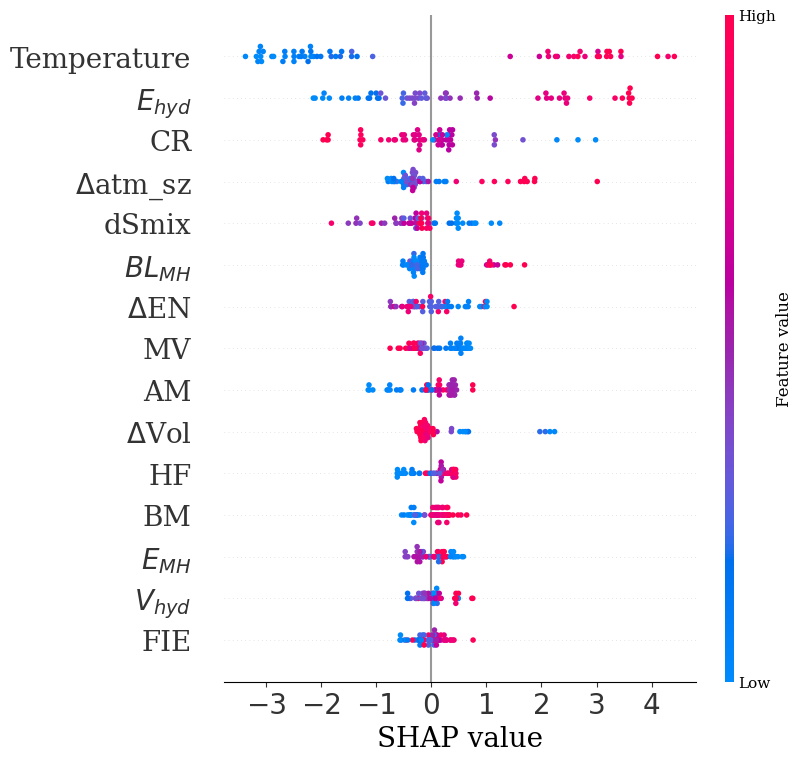

In [41]:
x_labels = ['Temperature',  '$E_{hyd}$','CR','$\Delta$atm_sz','dSmix','$BL_{MH}$', '$\Delta$EN', 'MV', 
            'AM', '$\Delta$Vol', 'HF', 'BM' ,'$E_{MH}$','$V_{hyd}$', 'FIE', ]
shap.summary_plot(shap_values, X_test,show=False)
ax = plt.gca()
ax.set_yticklabels(x_labels)
ax.set_yticks(range(len(x_labels)))
ax.set_yticklabels(x_labels[::-1],fontsize=20)
plt.xticks(fontsize=20,fontname="DejaVu Sans")
ax.set_xlabel("SHAP value",fontsize=20)
plt.savefig('OUTPUT/SHAP_summary.png',format='png',dpi=800, bbox_inches='tight')
plt.show()

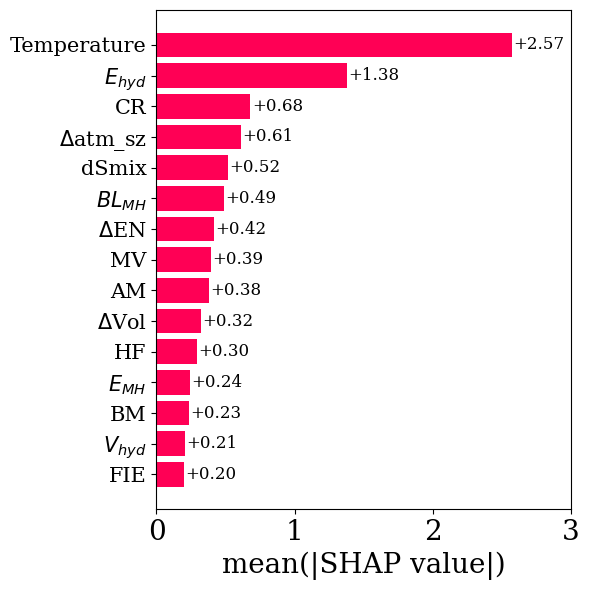

In [42]:
mean_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns
# Sort by importance
sorted_idx = np.argsort(mean_shap)[::-1]
sorted_means = mean_shap[sorted_idx]
sorted_features = [r'Temperature', r'$E_{hyd}$', r'CR', r'$\Delta$atm_sz', r'dSmix',
            r'$BL_{MH}$', r'$\Delta$EN', r'MV', r'AM', r'$\Delta$Vol', r'HF',
             r'$E_{MH}$', r'BM', r'$V_{hyd}$', r'FIE']
# Bar plot manually (instead of shap.plots.bar)
fig, ax = plt.subplots(figsize=(6, 6))
plt.locator_params(nbins=5)
ax.barh(range(len(sorted_means)), sorted_means, align="center",color= "#ff0055")
ax.set_yticks(range(len(sorted_means)))
ax.set_yticklabels(sorted_features,fontsize=15)
ax.invert_yaxis()  # most important at top
ax.set_xlabel("mean(|SHAP value|)",fontsize=20)
# Add SHAP values at the end of bars
for i, v in enumerate(sorted_means):
    ax.text(v + 0.01, i, f"{ v:+.2f}", va="center", fontsize=12)
plt.xlim(0,3)
plt.xticks(fontsize=20)
plt.tight_layout()

plt.savefig('OUTPUT/SHAP_FI.png',format='png',dpi=800, bbox_inches='tight')
plt.show()